Use conda environment `conda_envs/cool.yml` to run this notebook.

In [1]:
import pandas as pd
import numpy as np
import bioframe as bf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import bbi


# Matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

In [2]:
## Load features

# Gene expression
tpm_path = "/tank/projects/schizophrenia_2021/data/kozlenkov2018/RNA-seq/kozlenkov.logTPM_counts.csv.gz"
koz_cnts = pd.read_table(tpm_path, sep=',')
koz_cnts = bf.expand(koz_cnts, 2000)

# H3K27me3
mer_dir = '/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/broadPeak/'
me3_path = {
    'EN_R1': mer_dir + 'GLU_REP1_peaks.flt.broadPeak.gz',
    'EN_R2': mer_dir + 'GLU_REP2_peaks.flt.broadPeak.gz',
    'IN_R1': mer_dir + 'GABA_REP1_peaks.flt.broadPeak.gz',
    'IN_R2': mer_dir + 'GABA_REP2_peaks.flt.broadPeak.gz',   
}
me3_reps = {rep: bf.read_table(me3_path[rep], schema='broadPeak') 
            for rep in me3_path.keys()}
me3_ct = {}
me3_ct['GLU'] = bf.overlap(me3_reps['EN_R1'], me3_reps['EN_R2'], how='inner', return_overlap=True)\
    .loc[:, ['chrom', 'overlap_start', 'overlap_end']]\
    .rename(columns={'overlap_start': 'start', 'overlap_end': 'end'})
me3_ct['GABA'] = bf.overlap(me3_reps['IN_R1'], me3_reps['IN_R2'], how='inner', return_overlap=True)\
    .loc[:, ['chrom', 'overlap_start', 'overlap_end']]\
    .rename(columns={'overlap_start': 'start', 'overlap_end': 'end'})

# BMI1
bmi_peak_path = "/tank/projects/rina/tian23/new_bmi/new_bmi_result/bwa/merged_library/macs3/narrow_peak/BMI1_NEUN_merged_peaks.narrowPeak"
bmi_peak = bf.read_table(bmi_peak_path, schema='narrowPeak')

# ATAC-seq
atac_peak_path = "/media/backup2/PsychEncode/BrainTF/ATAC-seq/1224_1230_DLPFC_NeuN_idr.optimal_peak.narrowPeak.gz"
atac_peak = bf.read_table(atac_peak_path, schema='narrowPeak')

# BHLHE40
bhlh_peak_path = "/media/backup2/PsychEncode/BrainTF/processed/BHLHE40_DLPFC-NeuN_Output_idr.optimal_peak.regionPeak.gz"
bhlh_peak = bf.read_table(bhlh_peak_path, schema='narrowPeak')

# Pol2
pol2_peak_path = "/media/backup2/PsychEncode/BrainTF/processed/Pol2_DLPFC-NeuN_Output_idr.optimal_peak.regionPeak.gz"
pol2_peak = bf.read_table(pol2_peak_path, schema='narrowPeak')

# CTCF
ctcf_peak_path = "/media/backup2/PsychEncode/BrainTF/processed/CTCF_DLPFC-NEUN_idr.optimal_peak.regionPeak.gz"
ctcf_peak = bf.read_table(ctcf_peak_path, schema='narrowPeak')

# Dot anchors
hand_anch_path = "../data/polycomb_dot_anchors.5kb.16_06_25.csv"
hand_anch = pd.read_csv(hand_anch_path)
# hand_anch_path = "Supp.Table_polycomb_dot_anchors.5kb.xlsx"
# hand_anch = pd.read_excel(hand_anch_path, na_values=['-'])\
#     .dropna(subset=['start_new', 'end_new'])
# hand_anch[['start', 'end']] = hand_anch[['start_new', 'end_new']].astype(int)
# hand_anch = hand_anch.drop(columns=['start_new', 'end_new'])
print(hand_anch.shape)

(262, 4)


# CGI not merged

In [30]:
# Load CGI
# cgi_path = "/tank/projects/schizophrenia_2021/data/cpgIslandExt.hg38.flt.bed.gz"
# cgi = bf.read_table(cgi_path, schema='bed3')
cgi_path = "/tank/projects/polycomb/results/2025.04.10/CpG_filtered (1).bed.gz"
cgi = pd.read_table(cgi_path)

# Drop bad chromosomes
cgi = cgi.loc[cgi['chrom'].str.contains("^chr[0-9,X]*$")]

# cgi = bf.merge(cgi, 5000)
# cgi['length'] = cgi['end'] - cgi['start']

print(cgi.shape[0])
cgi.head()

24171


,chrom,start,end,length
0,chr1,904314,905239,925
1,chr1,908919,910503,1584
2,chr1,919385,919593,208
3,chr1,923590,926252,2662
4,chr1,933952,934964,1012


In [31]:
# Overlap with features
def add_feature(cgi_df, feature_df, col_name):
    cgi_olap = bf.overlap(cgi_df, feature_df, how='inner', return_index=True)\
        .drop_duplicates(['chrom', 'start', 'end'])

    # Write info to cgi table
    cgi_df[col_name] = False
    cgi_df.loc[cgi_olap['index'], col_name] = True
    return


# Cell type-specific features
for ct in ['GLU', 'GABA']:
    # Gene expression
    expr_gene_ct = koz_cnts.loc[koz_cnts[f'log2TPM_pl_1_{ct}'] > 1]
    add_feature(cgi, expr_gene_ct, f'near_expr_{ct}')

    # H3K27me3
    add_feature(cgi, bf.expand(me3_ct[ct], 1000), f'near_me3_{ct}')

# BMI1
add_feature(cgi, bmi_peak, 'near_bmi1')

# ATAC-seq
add_feature(cgi, atac_peak, 'near_atac')

# Dot anchors
add_feature(cgi, hand_anch, 'near_anch')

<Axes: xlabel='length', ylabel='Count'>

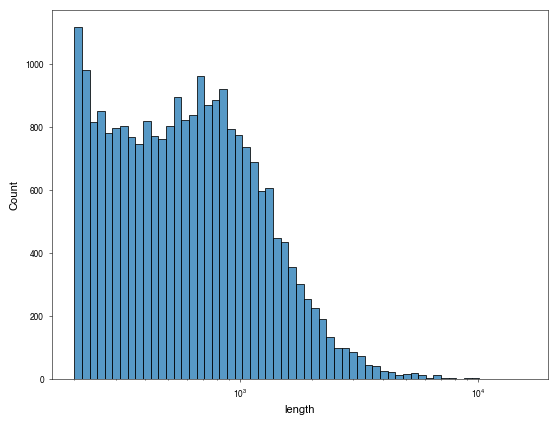

In [33]:
sns.histplot(cgi['length'], log_scale=True)

In [47]:
cgi['length'].median()

585.0

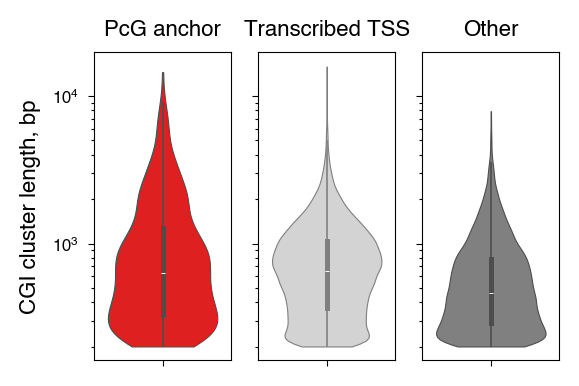

In [34]:
fig, axs = plt.subplots(1, 3, figsize=[3, 2], dpi=200, sharey=True)
grp_color = ['red', 'lightgrey', 'grey']

me3_grps = {
    'PcG anchor': cgi.loc[cgi['near_anch']],
    'Transcribed TSS': cgi.loc[~cgi['near_anch'] & cgi[f'near_expr_{ct}']],
    'Other': cgi.loc[~cgi['near_anch'] & ~cgi[f'near_expr_{ct}']],
}

for i, (grp_name, grp_df) in enumerate(me3_grps.items()):
    ax = axs[i]
    # sns.boxplot(data=grp_df, y='length', ax=ax, linewidth=0.4, 
    #                showfliers=False, color=grp_color[i])
    sns.violinplot(data=grp_df, y='length', ax=ax, linewidth=0.4, color=grp_color[i], cut=0, log_scale=[False, 10])
    ax.set_title(grp_name)
    ax.set_ylabel('CGI length, bp')

In [7]:
# cgi[['chrom', 'start', 'end']].to_csv("all_cgi_from_rina.bed", sep='\t', index=False, header=False)

In [8]:
cgi[['near_bmi1', 'near_expr_GLU', 'near_expr_GABA']].value_counts()

near_bmi1  near_expr_GLU  near_expr_GABA
False      True           True              8589
True       True           True              7104
False      False          False             4232
True       False          False             2626
False      True           False              616
           False          True               428
True       True           False              327
           False          True               249
Name: count, dtype: int64

In [9]:
# Fraction of BMI1
n_cgi = cgi.shape[0]
print(
    n_cgi,
    cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100,
    cgi.loc[~cgi['near_bmi1'] & (cgi['near_expr_GLU'] | cgi['near_expr_GABA'])].shape[0] / n_cgi * 100,
    cgi.loc[~cgi['near_bmi1'] & ~cgi['near_expr_GLU'] & ~cgi['near_expr_GABA']].shape[0] / n_cgi * 100,
)


24171 42.63787182987878 39.85354350254437 17.508584667576848


([<matplotlib.axis.YTick at 0x7f8d4504b290>], [Text(0, 0, '')])

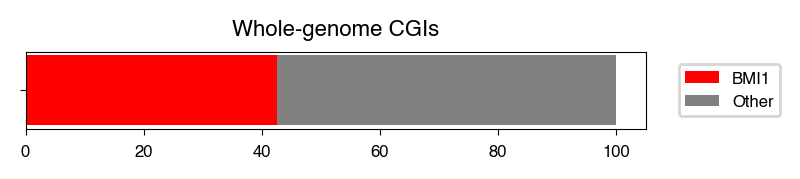

In [10]:
n_bmi = cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100

bars = [n_bmi, 
        100 - n_bmi]
labs = ['BMI1', 'Other']
cols = ['red', 'grey']
left=0

plt.figure(figsize=[4, 0.5], dpi=200)
for bar, col, lab in zip(bars, cols, labs):
    plt.barh(0, bar, left=left, color=col, label=lab)
    left+=bar

plt.title('Whole-genome CGIs')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
plt.yticks([0], [''])

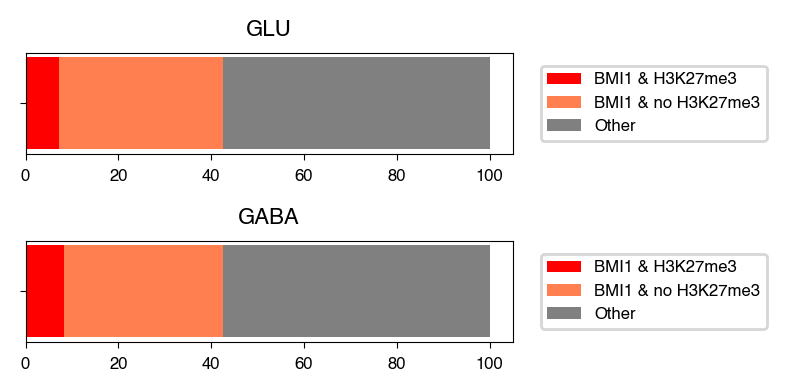

In [11]:
# EN
# n_bmi = cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100
fig, axs = plt.subplots(2, 1, figsize=[4, 2], dpi=200)
for i, ct in enumerate(['GLU', 'GABA']):
    n_bmi_me3 = cgi.loc[cgi['near_bmi1'] & cgi[f'near_me3_{ct}']].shape[0] / n_cgi * 100
    n_bmi_no_me3 = cgi.loc[cgi['near_bmi1'] & ~cgi[f'near_me3_{ct}']].shape[0] / n_cgi * 100
    
    bars = [n_bmi_me3, n_bmi_no_me3, 100 - n_bmi_me3 - n_bmi_no_me3]
    labs = ['BMI1 & H3K27me3', 'BMI1 & no H3K27me3', 'Other']
    cols = ['red', 'coral', 'grey']
    left=0
    
    # plt.figure(figsize=[4, 0.5], dpi=200)
    ax = axs[i]
    for bar, col, lab in zip(bars, cols, labs):
        ax.barh(0, bar, left=left, color=col, label=lab)
        left+=bar
    
    ax.set_title(ct)
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
    ax.set_yticks([0], [''])

plt.tight_layout()

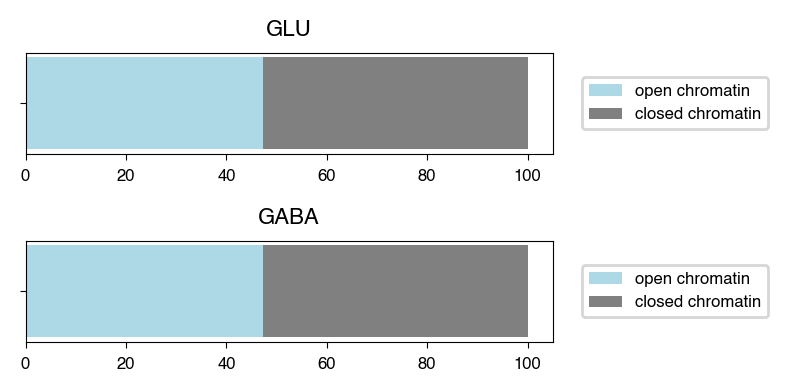

In [12]:
# EN
# n_bmi = cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100
fig, axs = plt.subplots(2, 1, figsize=[4, 2], dpi=200)
for i, ct in enumerate(['GLU', 'GABA']):
    n_atac = cgi.loc[cgi[f'near_atac']].shape[0] / n_cgi * 100
    
    bars = [n_atac, 100 - n_atac]
    labs = ['open chromatin', 'closed chromatin']
    cols = ['lightblue', 'grey']
    left=0
    
    # plt.figure(figsize=[4, 0.5], dpi=200)
    ax = axs[i]
    for bar, col, lab in zip(bars, cols, labs):
        ax.barh(0, bar, left=left, color=col, label=lab)
        left+=bar
    
    ax.set_title(ct)
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
    ax.set_yticks([0], [''])

plt.tight_layout()

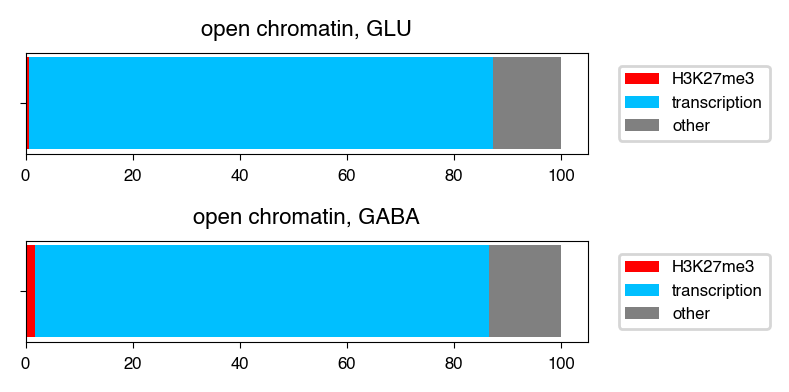

In [13]:
# OPEN chromatin

plot_df = cgi.loc[cgi[f'near_atac']]
n_plot_df = plot_df.shape[0]

fig, axs = plt.subplots(2, 1, figsize=[4, 2], dpi=200)
for i, ct in enumerate(['GLU', 'GABA']):
    n_me3 = plot_df.loc[plot_df[f'near_me3_{ct}'] & ~plot_df[f'near_expr_{ct}'] ].shape[0] / n_plot_df * 100
    n_expr = plot_df.loc[~plot_df[f'near_me3_{ct}'] & plot_df[f'near_expr_{ct}']].shape[0] / n_plot_df * 100
    n_atac = plot_df.loc[~plot_df[f'near_me3_{ct}'] & ~plot_df[f'near_expr_{ct}']].shape[0] / n_plot_df * 100
    
    bars = [n_me3, n_expr, 100 - n_me3 - n_expr ]
    labs = ['H3K27me3', 'transcription', 'other']
    cols = ['red', 'deepskyblue', 'grey']
    left=0
    
    # plt.figure(figsize=[4, 0.5], dpi=200)
    ax = axs[i]
    for bar, col, lab in zip(bars, cols, labs):
        ax.barh(0, bar, left=left, color=col, label=lab)
        left+=bar
    
    ax.set_title("open chromatin, " + ct)
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
    ax.set_yticks([0], [''])

plt.tight_layout()

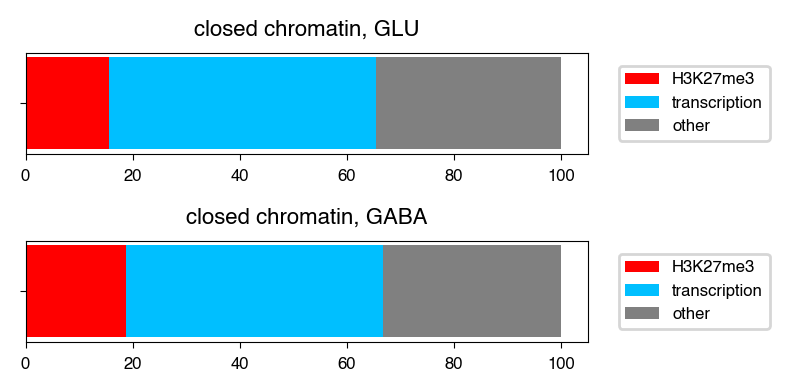

In [14]:
# OPEN chromatin

plot_df = cgi.loc[~cgi[f'near_atac']]
n_plot_df = plot_df.shape[0]

fig, axs = plt.subplots(2, 1, figsize=[4, 2], dpi=200)
for i, ct in enumerate(['GLU', 'GABA']):
    n_me3 = plot_df.loc[plot_df[f'near_me3_{ct}'] & ~plot_df[f'near_expr_{ct}'] ].shape[0] / n_plot_df * 100
    n_expr = plot_df.loc[~plot_df[f'near_me3_{ct}'] & plot_df[f'near_expr_{ct}']].shape[0] / n_plot_df * 100
    n_atac = plot_df.loc[~plot_df[f'near_me3_{ct}'] & ~plot_df[f'near_expr_{ct}']].shape[0] / n_plot_df * 100
    
    bars = [n_me3, n_expr, 100 - n_me3 - n_expr ]
    labs = ['H3K27me3', 'transcription', 'other']
    cols = ['red', 'deepskyblue', 'grey']
    left=0
    
    # plt.figure(figsize=[4, 0.5], dpi=200)
    ax = axs[i]
    for bar, col, lab in zip(bars, cols, labs):
        ax.barh(0, bar, left=left, color=col, label=lab)
        left+=bar
    
    ax.set_title("closed chromatin, " + ct)
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
    ax.set_yticks([0], [''])

plt.tight_layout()

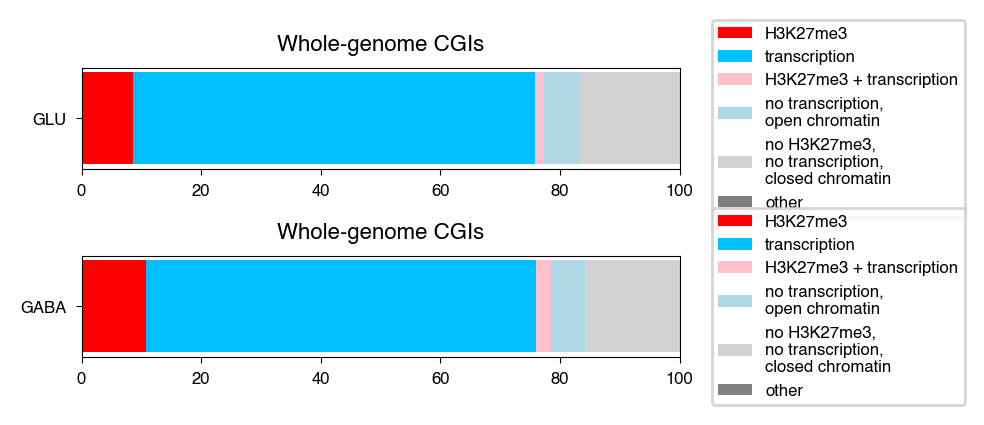

In [15]:
# EN
# n_bmi = cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100
n_cgi = cgi.shape[0]
fig, axs = plt.subplots(2, 1, figsize=[5, 2], dpi=200)
for i, ct in enumerate(['GLU', 'GABA']):
    n_me3 = cgi.loc[cgi[f'near_me3_{ct}'] & ~cgi[f'near_expr_{ct}']].shape[0] / n_cgi * 100
    n_expr = cgi.loc[~cgi[f'near_me3_{ct}'] & cgi[f'near_expr_{ct}']].shape[0] / n_cgi * 100
    n_me3_expr = cgi.loc[cgi[f'near_me3_{ct}'] & cgi[f'near_expr_{ct}']].shape[0] / n_cgi * 100
    n_atac = cgi.loc[~cgi[f'near_me3_{ct}'] & ~cgi[f'near_expr_{ct}'] & cgi[f'near_atac']].shape[0] / n_cgi * 100
    n_no_atac = cgi.loc[~cgi[f'near_me3_{ct}'] & ~cgi[f'near_expr_{ct}'] & ~cgi[f'near_atac']].shape[0] / n_cgi * 100
    
    bars = [n_me3, n_expr, n_me3_expr, n_atac, n_no_atac, 100 - n_me3 - n_expr - n_me3_expr - n_atac - n_no_atac]
    labs = ['H3K27me3', 'transcription', "H3K27me3 + transcription", "no transcription,\nopen chromatin", 
            "no H3K27me3,\nno transcription,\nclosed chromatin", 'other']
    cols = ['red', 'deepskyblue', 'pink', 'lightblue', 'lightgrey', 'grey']
    left=0
    
    # plt.figure(figsize=[4, 0.5], dpi=200)
    ax = axs[i]
    for bar, col, lab in zip(bars, cols, labs):
        ax.barh(0, bar, left=left, color=col, label=lab)
        left+=bar
    
    ax.set_title('Whole-genome CGIs')
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
    ax.set_yticks([0], [ct])

plt.tight_layout()

Does PRC2 have a preference for specific CGIs?

- "No transcription, open chromatin" fraction corresponds to weakly expressed genes and probably enhancer RNA
- "other" - most likely constitutive heterochromatin, that blocks PRC2 binding

Thus, most likely, PRC2 has no preference for particular CGIs. Instead, it occupies all possible CGIs that are not blocked by transcription machinery or constitutive heterochromatin.

In [16]:
koz_cnts.loc[koz_cnts['gene.name'].isin(['RANP6', 'MORF4'])]

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG
22177,ENSG00000213370,chr4,173631727,173636371,RANP6,processed_pseudogene,-,0.601393,0.000000,0.000000
32000,ENSG00000234801,chr4,173613935,173618906,MORF4,processed_pseudogene,-,0.753625,0.877005,1.092601


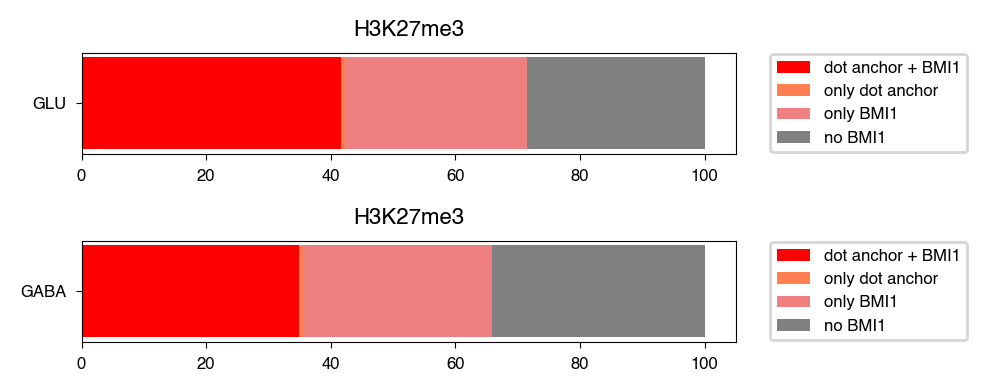

In [17]:
fig, axs = plt.subplots(2, 1, figsize=[5, 2], dpi=200)
for i, ct in enumerate(['GLU', 'GABA']):
    plot_df = cgi.loc[cgi[f'near_me3_{ct}'] & ~cgi[f'near_expr_{ct}']]
    n_plot_df = plot_df.shape[0]

    n_anch_bmi = plot_df.loc[plot_df[f'near_anch'] & plot_df[f'near_bmi1']].shape[0] / n_plot_df * 100
    n_anch = plot_df.loc[plot_df[f'near_anch'] & ~plot_df[f'near_bmi1']].shape[0] / n_plot_df * 100
    n_bmi = plot_df.loc[~plot_df[f'near_anch'] & plot_df[f'near_bmi1']].shape[0] / n_plot_df * 100
    # n_expr = plot_df.loc[cgi[f'near_expr_{ct}']].shape[0] / n_plot_df * 100
    
    bars = [n_anch_bmi, n_anch, n_bmi, 100 - n_anch - n_anch_bmi - n_bmi]
    labs = ['dot anchor + BMI1', 'only dot anchor', 'only BMI1', 'no BMI1']
    cols = ['red', 'coral', 'lightcoral', 'grey']
    left=0
    
    # plt.figure(figsize=[4, 0.5], dpi=200)
    ax = axs[i]
    for bar, col, lab in zip(bars, cols, labs):
        ax.barh(0, bar, left=left, color=col, label=lab)
        left+=bar
    
    ax.set_title("H3K27me3")
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
    ax.set_yticks([0], [ct])

plt.tight_layout()

polycomb interaction requires both PRC1 (BMI1) and PRC2 (H3K27me3)

- Why BMI1 is not bound everythere? **Weak H3K27me3 signal**
- Why some BMI1 do not form polycomb dots? **Weak BMI1 signal**

(plot average H3K27me3, BMI1, and ATAC-seq profiles for 3 groups)

In [18]:
cgi.loc[cgi[f"near_me3_{ct}"], ['near_anch', 'near_bmi1', f'near_expr_{ct}']].value_counts()

near_anch  near_bmi1  near_expr_GABA
True       True       False             902
False      False      False             883
           True       False             783
           False      True              233
           True       True              224
True       True       True              113
           False      False              19
                      True                2
Name: count, dtype: int64

In [19]:
cgi.loc[cgi[f"near_me3_{ct}"] & cgi[f"near_anch"] & cgi[f'near_expr_{ct}']]

,chrom,start,end,length,near_expr_GLU,near_me3_GLU,near_expr_GABA,near_me3_GABA,near_bmi1,near_atac,near_anch
934,chr1,44417464,44418232,768,True,True,True,True,True,False,True
1908,chr1,213982657,213983508,851,True,True,True,True,True,False,True
1909,chr1,213985383,213985737,354,True,True,True,True,True,False,True
1910,chr1,213987455,213987691,236,True,True,True,True,True,True,True
1911,chr1,213989165,213989394,229,True,True,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
23722,chr9,123999447,124000404,957,True,False,True,True,True,False,True
23723,chr9,124008384,124009812,1428,True,False,True,True,True,False,True
23724,chr9,124010967,124013287,2320,True,False,True,True,True,True,True
23725,chr9,124013820,124014044,224,True,False,True,True,True,False,True


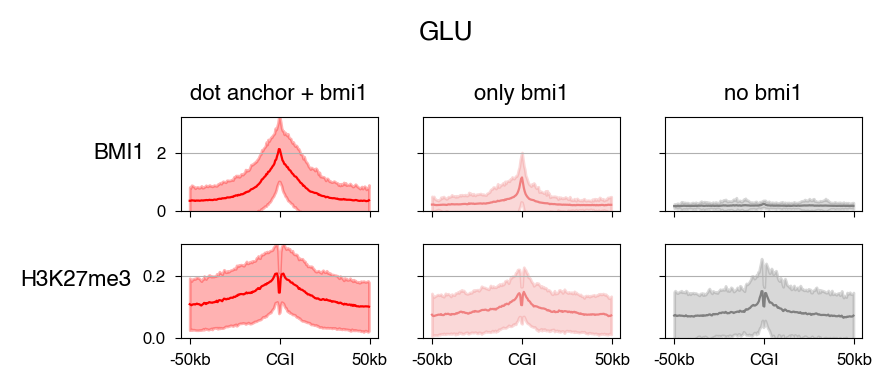

In [20]:
# plot average profiles
ct = 'GLU'
offset, nbins = 50_000, 200

prof_paths = {
    "BMI1": "/tank/projects/rina/tian23/new_bmi/new_bmi_result/bwa/merged_library/bigwig/BMI1_NEUN_DLPFC_merged.bigWig",
    "H3K27me3": f"/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/{ct}.merged.bigWig",
    # "ATAC-seq": "/media/backup2/PsychEncode/BrainTF/ATAC-seq/1224_1230_DLPFC_NeuN_basename_prefix.pooled.pval.signal.bigwig"
}

me3_grps = {
    'dot anchor + bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & cgi['near_anch'] & cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
    'only bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & ~cgi['near_anch'] & cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
    'no bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & ~cgi['near_anch'] & ~cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
}
grp_color = ['red', 'lightcoral', 'grey']

fig, axs = plt.subplots(len(prof_paths), len(me3_grps), dpi=200, 
                        figsize=[1.5 * len(me3_grps), 0.7 * len(prof_paths) + 0.5], 
                        sharey='row', sharex=True)

for j, (grp_name, grp_df) in enumerate(me3_grps.items()):
    plot_df = grp_df.copy(deep=True)
    plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
    plot_df['start'] = plot_df['mid'] - offset
    plot_df['end'] = plot_df['mid'] + offset
    
    for i, (prof, path) in enumerate(prof_paths.items()):
        s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], 
                        bins=nbins)
        s_mean = np.nanmean(s, axis=0)
        s_std = np.nanstd(s, axis=0)

        ax = axs[i, j] 
        ax.plot(s_mean, linewidth=0.8, c=grp_color[j])
        ax.fill_between(np.arange(nbins), s_mean-s_std, s_mean+s_std, 
                        alpha=0.3, color=grp_color[j])
        # ax.fill_between(np.arange(nbins), [0]*nbins, np.mean(s, axis=0))

        ax.set_xticks([0, nbins//2, nbins], [f"{-offset//1000}kb", 'CGI', f"{offset//1000}kb"])
        ax.grid(axis='y', which='both', linewidth=0.4)

        if j == 0:
            ax.set_ylim([0, (s_mean+s_std).max()])
            ax.set_ylabel(prof, rotation='horizontal', ha='right')
        if i == 0:
            ax.set_title(grp_name)

plt.suptitle(ct)
plt.tight_layout()

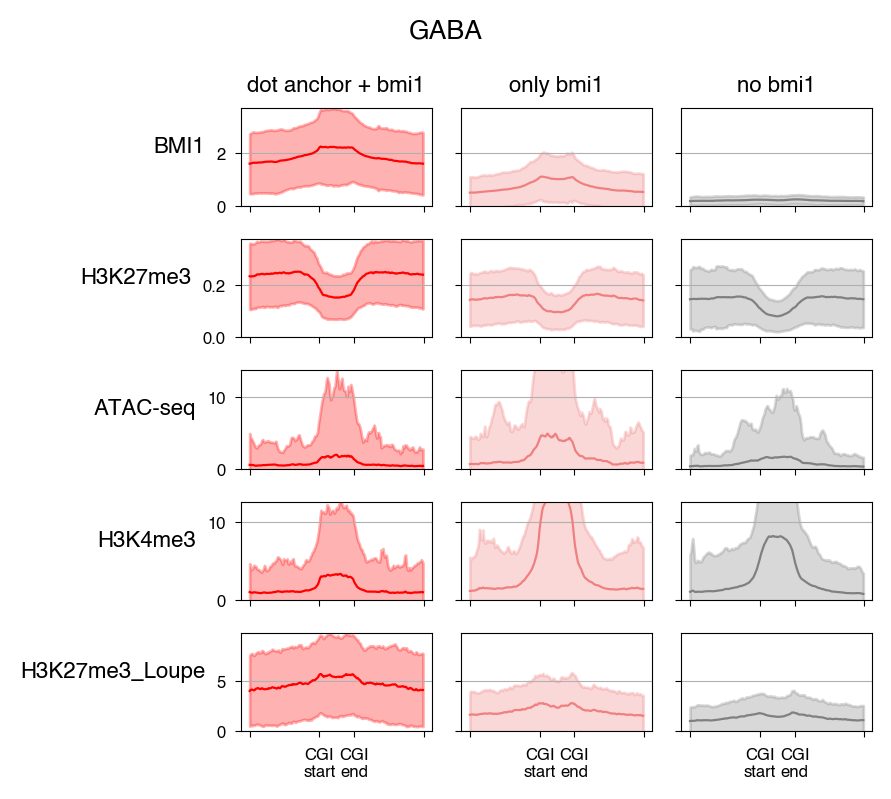

In [25]:
# plot relative to CGI
ct = 'GABA'
# offset, nbins_offset, nbins_cgi = 2_000, 75, 50
# nbins_tot = 2 * nbins_offset + nbins_cgi
offset, nbins = 2, 200
offset_tot = 2 * offset + 1

prof_paths = {
    "BMI1": "/tank/projects/rina/tian23/new_bmi/new_bmi_result/bwa/merged_library/bigwig/BMI1_NEUN_DLPFC_merged.bigWig",
    "H3K27me3": f"/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/{ct}.merged.bigWig",
    "ATAC-seq": "/media/backup2/PsychEncode/BrainTF/ATAC-seq/1224_1230_DLPFC_NeuN_basename_prefix.pooled.pval.signal.bigwig",
    "H3K4me3": "/media/backup2/PsychEncode/BrainTF/processed/H3K4me3_DLPFC-NEUN_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    "H3K27me3_Loupe": "/media/backup2/PsychEncode/BrainTF/processed/H3K27me3_DLPFC-NeuN_Output_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig"
}

me3_grps = {
    'dot anchor + bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & cgi['near_anch'] & cgi['near_bmi1']],
    'only bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & ~cgi['near_anch'] & cgi['near_bmi1']],
    'no bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & ~cgi['near_anch'] & ~cgi['near_bmi1']],
}
grp_color = ['red', 'lightcoral', 'grey']

fig, axs = plt.subplots(len(prof_paths), len(me3_grps), dpi=200, 
                        figsize=[1.5 * len(me3_grps), 0.7 * len(prof_paths) + 0.5], 
                        sharey='row', sharex=True)

for j, (grp_name, grp_df) in enumerate(me3_grps.items()):
    plot_df = grp_df.copy(deep=True)
    # plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
    # plot_df['start_reg'] = plot_df['start'] - offset
    # plot_df['end_reg'] = plot_df['end'] + offset
    plot_df['start_reg'] = plot_df['start'] - offset * plot_df['length']
    plot_df['end_reg'] = plot_df['end'] + offset * plot_df['length']
    
    for i, (prof, path) in enumerate(prof_paths.items()):
        # s_left = bbi.stackup(path, plot_df['chrom'], plot_df['start_reg'], plot_df['start'], 
        #                      bins=nbins_offset)
        # s_cgi = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], 
        #                      bins=nbins_cgi)
        # s_right = bbi.stackup(path, plot_df['chrom'], plot_df['end'], plot_df['end_reg'], 
        #                       bins=nbins_offset)
        # s = np.concatenate([s_left, s_cgi, s_right], axis=1)
        s = bbi.stackup(path, plot_df['chrom'], plot_df['start_reg'], plot_df['end_reg'], 
                        bins=nbins)
        s_mean = np.nanmean(s, axis=0)
        s_std = np.nanstd(s, axis=0)

        ax = axs[i, j] 
        ax.plot(s_mean, linewidth=0.8, c=grp_color[j])
        # ax.fill_between(np.arange(nbins_tot), s_mean-s_std, s_mean+s_std, 
        #                 alpha=0.3, color=grp_color[j])
        ax.fill_between(np.arange(nbins), s_mean-s_std, s_mean+s_std, 
                        alpha=0.3, color=grp_color[j])

        # ax.set_xticks([0, nbins_offset, nbins_offset + nbins_cgi, nbins_tot], 
        #               [f"{-offset//1000}kb", 'CGI\nstart', 'CGI\nend', f"{offset//1000}kb"])
        ax.set_xticks([0, nbins / offset_tot * offset, nbins / offset_tot * (offset + 1), nbins], 
                      [f"", 'CGI\nstart', 'CGI\nend', f""])
        ax.grid(axis='y', which='both', linewidth=0.4)

        if j == 0:
            ax.set_ylim([0, (s_mean+s_std).max()])
            ax.set_ylabel(prof, rotation='horizontal', ha='right')
        if i == 0:
            ax.set_title(grp_name)

plt.suptitle(ct)
plt.tight_layout()

In [26]:
for j, (grp_name, grp_df) in enumerate(me3_grps.items()):
    print(grp_name, grp_df['length'].median())

dot anchor + bmi1 652.0
only bmi1 827.0
no bmi1 542.5


In [27]:
gene = 'RCC2'

koz_cnts.loc[koz_cnts['gene.name'] == 'LRRC38']

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG
10717,ENSG00000162494,chr1,13472972,13516003,LRRC38,protein_coding,-,0.006142,1.418598,0.0


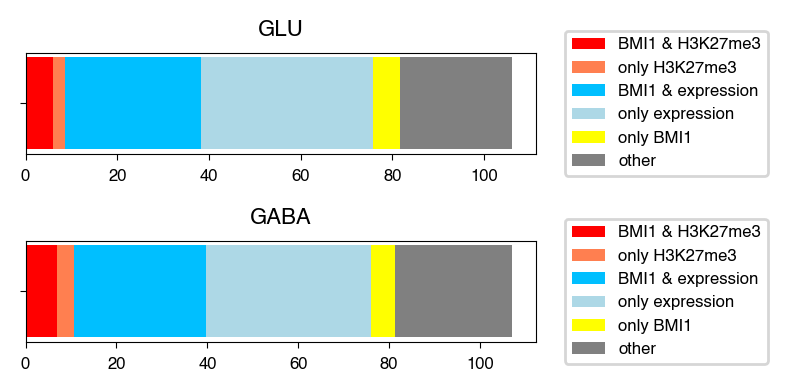

In [28]:
# EN
# n_bmi = cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100
fig, axs = plt.subplots(2, 1, figsize=[4, 2], dpi=200)
for i, ct in enumerate(['GLU', 'GABA']):
    n_bmi_me3 = cgi.loc[cgi['near_bmi1'] & cgi[f'near_me3_{ct}'] & ~cgi[f'near_expr_{ct}']].shape[0] / n_cgi * 100
    n_me3_only = cgi.loc[~cgi['near_bmi1'] & cgi[f'near_me3_{ct}'] & ~cgi[f'near_expr_{ct}']].shape[0] / n_cgi * 100
    n_bmi_expr = cgi.loc[cgi['near_bmi1'] & ~cgi[f'near_me3_{ct}'] & cgi[f'near_expr_{ct}']].shape[0] / n_cgi * 100
    n_expr_only = cgi.loc[~cgi['near_bmi1'] & ~cgi[f'near_me3_{ct}'] & cgi[f'near_expr_{ct}']].shape[0] / n_cgi * 100
    n_bmi_only = cgi.loc[cgi['near_bmi1'] & ~cgi[f'near_me3_{ct}'] & ~cgi[f'near_expr_{ct}']].shape[0] / n_cgi * 100
    
    bars = [n_bmi_me3, n_me3_only, n_bmi_expr, n_expr_only, n_bmi_only, 100 - n_bmi_expr - n_bmi_only - n_me3_only - n_expr_only]
    labs = ['BMI1 & H3K27me3', 'only H3K27me3', 'BMI1 & expression', 'only expression', 'only BMI1', 'other']
    cols = ['red', 'coral', 'deepskyblue', 'lightblue', 'yellow', 'grey']
    left=0
    
    # plt.figure(figsize=[4, 0.5], dpi=200)
    ax = axs[i]
    for bar, col, lab in zip(bars, cols, labs):
        ax.barh(0, bar, left=left, color=col, label=lab)
        left+=bar
    
    ax.set_title(ct)
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
    ax.set_yticks([0], [''])

plt.tight_layout()

We assume that H3K27me3-covered genes are not expressed. In reality, 100-200 CGI overlap H3K27me3 and are near expressed genes, but removing this requires assigning CGIs more accurately. 

CGI without me3 or transcription are presumably constitutive heterochromatin, meaning that something restricts PRC1 from binding there (check ATAC-seq)

In [69]:
cgi.loc[~cgi['near_me3_GABA'] &
        ~cgi['near_me3_GLU'] & 
        ~cgi['near_expr_GABA'] &
        ~cgi['near_expr_GLU'] & 
        cgi['near_anch']]

,chrom,start,end,length,near_expr_GLU,near_expr_GABA,near_bmi1,near_anch,near_me3_GLU,near_me3_GABA
13452,chr2,172108076,172108514,438,False,False,True,True,False,False
13847,chr2,236159427,236160190,763,False,False,True,True,False,False
16937,chr4,8908591,8908877,286,False,False,False,True,False,False
17095,chr4,54091812,54092375,563,False,False,True,True,False,False
18872,chr6,27519033,27519290,257,False,False,True,True,False,False
19489,chr6,149925616,149926121,505,False,False,True,True,False,False
21365,chr7,157039984,157040267,283,False,False,False,True,False,False
21475,chr8,10726306,10726746,440,False,False,False,True,False,False
22241,chr9,826582,826800,218,False,False,False,True,False,False
22769,chr9,123339498,123339759,261,False,False,True,True,False,False


In [70]:
cgi[['near_me3_GABA', 'near_me3_GLU', 'near_expr_GABA', 'near_expr_GLU', 'near_anch']].value_counts()

near_me3_GABA  near_me3_GLU  near_expr_GABA  near_expr_GLU  near_anch
False          False         True            True           False        14509
                             False           False          False         4089
True           True          False           False          False         1151
False          False         False           True           False          649
True           False         False           False          False          576
False          False         True            False          False          509
True           True          False           False          True           505
               False         True            True           False          265
False          True          False           False          False          183
True           False         False           True           False          149
               True          True            True           False          145
False          True          True            True           F

In [60]:
cgi[['near_me3_GABA', 'near_expr_GABA', 'near_anch']].value_counts()

near_me3_GABA  near_expr_GABA  near_anch
False          True            False        15483
               False           False         5942
True           False           False          920
                               True           468
               True            False          146
False          False           True           104
               True            True            61
True           True            True            58
Name: count, dtype: int64

([<matplotlib.axis.YTick at 0x7f8d44eedbb0>], [Text(0, 0, '')])

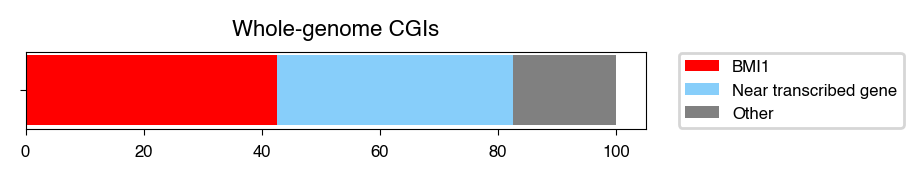

In [29]:
bars = [cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100, 
           cgi.loc[~cgi['near_bmi1'] & (cgi['near_expr_GLU'] | cgi['near_expr_GABA'])].shape[0] / n_cgi * 100,
           cgi.loc[~cgi['near_bmi1'] & ~cgi['near_expr_GLU'] & ~cgi['near_expr_GABA']].shape[0] / n_cgi * 100]
labs = ['BMI1', 'Near transcribed gene', 'Other']
cols = ['red', 'lightskyblue', 'grey']
left=0

plt.figure(figsize=[4, 0.5], dpi=200)
for bar, col, lab in zip(bars, cols, labs):
    plt.barh(0, bar, left=left, color=col, label=lab)
    left+=bar

plt.title('Whole-genome CGIs')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
plt.yticks([0], [''])

In [31]:
# Find CGI overlapping dot anchors
cgi_anch = bf.overlap(cgi, hand_anch, how='inner', suffixes=['', '_anch'], 
                      return_index=True)\
    .drop_duplicates(['chrom', 'start', 'end'])

# Write info to cgi table
cgi['near_anch'] = False
cgi.loc[cgi_anch['index'], 'near_anch'] = True

print(cgi_anch.shape[0])
cgi_anch.head()

691


,index,chrom,start,end,length,near_expr_GLU,near_expr_GABA,near_bmi1,index_anch,chrom_anch,start_anch,end_anch,genes_anch
0,2206,chr10,8049411,8056366,6955,False,False,True,22,chr10,8050000,8050000,"GATA3,GATA3-AS1"
1,2712,chr10,100729586,100731254,1668,False,False,True,28,chr10,100730000,100730000,PAX2
2,2980,chr10,129958426,129960523,2097,False,False,True,34,chr10,129960000,129960000,EBF3
3,9870,chr18,904577,905697,1120,True,True,True,95,chr18,900000,915000,"ADCYAP1,AP000894.2"
4,9871,chr18,906256,909573,3317,True,True,True,95,chr18,900000,915000,"ADCYAP1,AP000894.2"


In [34]:
cgi.loc[~cgi['near_bmi1'] & ~cgi['near_expr_GLU'] & ~cgi['near_expr_GABA'], ['near_me3_GLU', 'near_me3_GABA', 'near_anch']].value_counts()

near_me3_GLU  near_me3_GABA  near_anch
False         False          False        3699
              True           False         151
True          True           False          84
              False          False          31
False         False          True            7
True          False          True            3
False         True           True            2
Name: count, dtype: int64

In [35]:
cgi.loc[~cgi['near_bmi1'] & 
        ~cgi['near_expr_GLU'] & 
        ~cgi['near_expr_GABA'] & 
        ~cgi['near_me3_GLU'] & 
        cgi['near_me3_GABA'] & 
        ~cgi['near_anch']]

,chrom,start,end,length,near_expr_GLU,near_expr_GABA,near_bmi1,near_anch,near_me3_GLU,near_me3_GABA
158,chr1,2855561,2856100,539,False,False,False,False,False,True
169,chr1,3062711,3064194,1483,False,False,False,False,False,True
186,chr1,3247405,3248079,674,False,False,False,False,False,True
326,chr1,9495320,9495593,273,False,False,False,False,False,True
386,chr1,12063431,12064091,660,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
22610,chr9,96383242,96383803,561,False,False,False,False,False,True
22786,chr9,124450345,124450785,440,False,False,False,False,False,True
23105,chr9,136192667,136194246,1579,False,False,False,False,False,True
23244,chr9,137278161,137281653,3492,False,False,False,False,False,True


## How many CGI falls to centromeres and telomeres?

In [30]:
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens = bf.fetch_centromeres('hg38')

In [31]:
cgi_myst = cgi.loc[~cgi['near_bmi1'] & 
                    ~cgi['near_expr_GLU'] & 
                    ~cgi['near_expr_GABA'] & 
                    ~cgi['near_me3_GLU'] & 
                    ~cgi['near_me3_GABA'] & 
                    ~cgi['near_anch']]

n_cent = bf.overlap(cgi_myst, bf.expand(hg38_cens, int(1e7)), how='inner')\
            .drop_duplicates(['chrom', 'start', 'end']).shape[0]

print(cgi_myst.shape[0], n_cent)

3279 329


In [32]:
telo_size = int(5e6)
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_chromsizes = pd.DataFrame(hg38_chromsizes).reset_index()\
    .rename(columns={'name': 'chrom', 'length': 'end'})
hg38_chromsizes = hg38_chromsizes.loc[hg38_chromsizes['chrom'] != 'chrM']
hg38_chromsizes['start'] = 0

hg38_telo = hg38_chromsizes.copy()
hg38_telo['start'] += telo_size
hg38_telo['end'] -= telo_size
hg38_telo = bf.complement(hg38_telo, hg38_chromsizes)

n_telo = bf.overlap(cgi_myst, hg38_telo, how='inner')\
    .drop_duplicates(['chrom', 'start', 'end']).shape[0]

print(n_telo)

1253


([<matplotlib.axis.YTick at 0x7f8d39003470>], [Text(0, 0, '')])

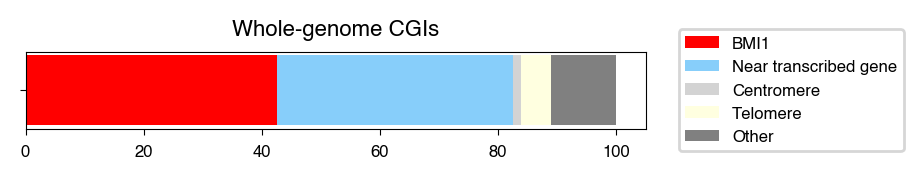

In [33]:
bars = [cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100, 
        cgi.loc[~cgi['near_bmi1'] & (cgi['near_expr_GLU'] | cgi['near_expr_GABA'])].shape[0] / n_cgi * 100,
        n_cent / n_cgi * 100,
        n_telo / n_cgi * 100,
        (cgi.loc[~cgi['near_bmi1'] & ~cgi['near_expr_GLU'] & ~cgi['near_expr_GABA']].shape[0] - n_cent - n_telo) / n_cgi * 100,]
labs = ['BMI1', 'Near transcribed gene', 'Centromere', 'Telomere', 'Other']
cols = ['red', 'lightskyblue', 'lightgrey', 'lightyellow', 'grey']
left=0

plt.figure(figsize=[4, 0.5], dpi=200)
for bar, col, lab in zip(bars, cols, labs):
    plt.barh(0, bar, left=left, color=col, label=lab)
    left+=bar

plt.title('Whole-genome CGIs')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
plt.yticks([0], [''])

([<matplotlib.axis.YTick at 0x7f8d3b19e2a0>], [Text(0, 0, '')])

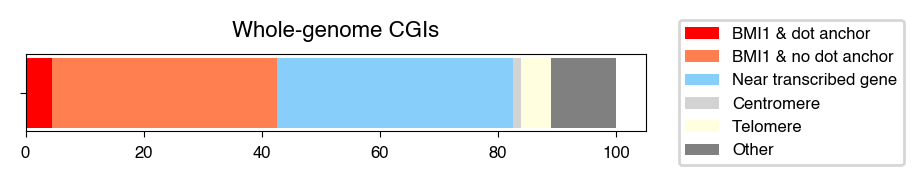

In [34]:
bars = [cgi.loc[cgi['near_bmi1'] & cgi['near_anch']].shape[0] / n_cgi * 100, 
        cgi.loc[cgi['near_bmi1'] & ~cgi['near_anch']].shape[0] / n_cgi * 100, 
        cgi.loc[~cgi['near_bmi1'] & (cgi['near_expr_GLU'] | cgi['near_expr_GABA'])].shape[0] / n_cgi * 100,
        n_cent / n_cgi * 100,
        n_telo / n_cgi * 100,
        (cgi.loc[~cgi['near_bmi1'] & ~cgi['near_expr_GLU'] & ~cgi['near_expr_GABA']].shape[0] - n_cent - n_telo) / n_cgi * 100,]
labs = ['BMI1 & dot anchor', 'BMI1 & no dot anchor', 'Near transcribed gene', 'Centromere', 'Telomere', 'Other']
cols = ['red', 'coral', 'lightskyblue', 'lightgrey', 'lightyellow', 'grey']
left=0

plt.figure(figsize=[4, 0.5], dpi=200)
for bar, col, lab in zip(bars, cols, labs):
    plt.barh(0, bar, left=left, color=col, label=lab)
    left+=bar

plt.title('Whole-genome CGIs')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
plt.yticks([0], [''])

## Look at PCGF targets in mESCs

In [81]:
pcgf_path = "/tank/projects/polycomb/data/scelfo2019_pcgf/table_s3_pcgf_target_genes.xlsx"
pcgf = pd.read_excel(pcgf_path)
print(pcgf.shape[0])
# pcgf['hand_gene'] = pcgf['EnsemblID'].map(m2h_gene.set_index('mouse.gene.id')['hand_gene'])
# pcgf.loc[pcgf['hand_gene'].isna(), 'hand_gene'] = False
pcgf.head()

6973


,chr,start,end,EnsemblID,GeneSymbol,strand,PcgfTarget,hand_gene
0,chr8,63111657,63155528,ENSMUSG00000031647,Mfap3l,+,Pcgf1,False
1,chr11,4086836,4115508,ENSMUSG00000034412,Tbc1d10a,+,Pcgf1,False
2,chr2,57090089,57223130,ENSMUSG00000026827,Gpd2,+,Pcgf1,False
3,chr14,72937760,73109349,ENSMUSG00000033487,Fndc3a,-,Pcgf1,False
4,chr2,25048240,25052333,ENSMUSG00000059555,Tor4a,-,Pcgf1,False


In [88]:
hand_anch['genes'].dropna().str.split(',').str[0]

array(['PAX7', 'RUNX3', 'RNF220', 'TAL1', 'FOXD2', 'DMRTA2', 'FOXD3',
       'LHX8', 'BARHL2', 'AC091614.2', 'GFI1', 'TBX15', 'LMX1A', 'LHX4',
       'LHX9', 'NR5A2', 'PROX1', 'HLX', 'NUP133', 'GATA3', 'SPAG6',
       'PTF1A', 'GAD2', 'ZNF503', 'NKX2-3', 'PAX2', 'TLX1', 'LBX1',
       'VAX1', 'EMX2', 'AL354863.1', 'HMX2', 'EBF3', 'DBX1', 'SLC6A5',
       'SLC17A6', 'PAX6', 'WT1', 'MIR670', 'ALX4', 'BSX', 'FLI1', 'BARX2',
       'HOXC4', 'HMGA2', 'ALX1', 'LHX5', 'TBX5', 'TBX3', 'AC009387.1',
       'FZD10', 'GJA3', 'LINC01079', 'GSX1', 'CDX2', 'FLT1', 'DLEU2',
       'PCDH8', 'POU4F1', 'SOX21', 'ZIC5', 'SOX1', 'SFTA3', 'PAX9',
       'FOXA1', 'OTX2', 'SIX6', 'SIX1', 'TMEM30B', 'GSC', 'AC018563.1',
       'MEIS2', 'ONECUT1', 'FOXB1', 'SKOR1', 'ISL2', 'NR2F2', 'CBLN1',
       'SALL1', 'IRX3', 'IRX5', 'ZFHX3', 'FENDRR', 'FOXC2', 'HS3ST3B1',
       'SLFN12', 'NEUROD2', 'HOXB1', 'IGF2BP1', 'TBX2', 'CBX2', 'ADCYAP1',
       'TGIF1', 'GATA6', 'SKOR2', 'ONECUT2', 'RAX', 'NOXA', 'SIX3',
       '

In [239]:
import re

# Extract gene names
hand_genes_all = hand_anch['genes'].dropna().str.split(',').str[0].values
# hand_genes_all = [item for sublist in hand_genes_all for item in sublist]

# remove transcripts and ncRNAs
regex = re.compile(r'(^LINC|^RNA|^MIR|^A[LCP][0-9]+|.*\-AS|.*\-DT|.*\-OT|^RF[0-9]+|^C[0-9]*orf[0-9]*)')
hand_pc = [i for i in hand_genes_all if not regex.match(i)]
print(len(hand_pc))
hand_pc[:5]

219


['PAX7', 'RUNX3', 'RNF220', 'TAL1', 'FOXD2']

([<matplotlib.axis.YTick at 0x7f2dceb856d0>], [Text(0, 0, '')])

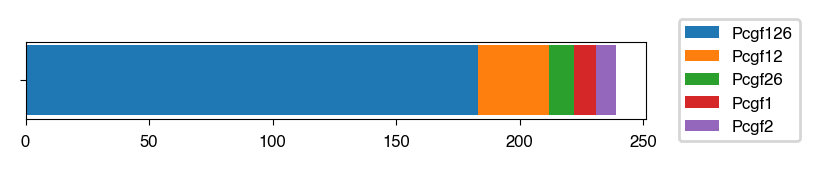

In [243]:
n_pcgf = pcgf.shape[0]
plot_df = pcgf.loc[pcgf['GeneSymbol'].str.upper().isin(hand_pc), 'PcgfTarget'].value_counts()

# n_bmi = cgi.loc[cgi['near_bmi1']].shape[0] / n_cgi * 100

bars = plot_df.values 
labs = plot_df.index
cols = sns.color_palette()
left=0

plt.figure(figsize=[4, 0.5], dpi=200)
for bar, col, lab in zip(bars, cols, labs):
    plt.barh(0, bar, left=left, color=col, label=lab)
    left+=bar

# plt.title('Genes within dot anchors')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
plt.yticks([0], [''])

In [173]:
# [gene for gene in hand_pc if gene not in pcgf['GeneSymbol'].str.upper().values]

In [167]:
pcgf_hand = pcgf.loc[pcgf['GeneSymbol'].str.upper().isin(hand_pc)]
pcgf_hand.loc[pcgf_hand['PcgfTarget'] == 'Pcgf2']

,chr,start,end,EnsemblID,GeneSymbol,strand,PcgfTarget
2161,chr2,74560035,74567216,ENSMUSG00000101174,Hoxd4,+,Pcgf2
2211,chr13,21871752,21872423,ENSMUSG00000058773,Hist1h1b,-,Pcgf2
2257,chr11,96143219,96146639,ENSMUSG00000056648,Hoxb8,+,Pcgf2
2320,chr6,52156364,52158623,ENSMUSG00000043219,Hoxa6,-,Pcgf2
2374,chr14,57742140,57752414,ENSMUSG00000040055,Gjb6,-,Pcgf2
2395,chr19,24752751,24936332,ENSMUSG00000041731,Pgm5,-,Pcgf2
2397,chr13,40811044,40825812,ENSMUSG00000021359,Tfap2a,-,Pcgf2
2398,chr11,96143219,96146629,ENSMUSG00000056648,Hoxb8,+,Pcgf2
2435,chr11,96164826,96167435,ENSMUSG00000038700,Hoxb5,+,Pcgf2
2440,chr13,40811044,40826976,ENSMUSG00000021359,Tfap2a,-,Pcgf2


In [168]:
pcgf_hand = pcgf.loc[pcgf['GeneSymbol'].str.upper().isin(hand_pc)]
pcgf_hand.loc[pcgf_hand['PcgfTarget'] == 'Pcgf26']

,chr,start,end,EnsemblID,GeneSymbol,strand,PcgfTarget
4536,chr13,31898515,31902504,ENSMUSG00000050295,Foxc1,+,Pcgf26
4547,chr8,123640071,123642794,ENSMUSG00000046714,Foxc2,+,Pcgf26
4568,chr6,52119061,52163066,ENSMUSG00000079560,Hoxa3,-,Pcgf26
4574,chr3,99057683,99158183,ENSMUSG00000027868,Tbx15,+,Pcgf26
4575,chr10,22537079,22539934,ENSMUSG00000045680,Tcf21,-,Pcgf26
4588,chr4,114578885,114581503,ENSMUSG00000055210,Foxd2,-,Pcgf26
4610,chr16,94344209,94345579,ENSMUSG00000062713,Sim2,+,Pcgf26
4611,chr2,74550050,74586328,ENSMUSG00000079277,Hoxd3,+,Pcgf26
4626,chr14,69790076,69793597,ENSMUSG00000044186,Nkx2-6,+,Pcgf26
4653,chr2,74564785,74586328,ENSMUSG00000079277,Hoxd3,+,Pcgf26


In [174]:
pcgf_hand = pcgf.loc[pcgf['GeneSymbol'].str.upper().isin(hand_pc)]
pcgf_hand.loc[pcgf_hand['PcgfTarget'] == 'Pcgf1']

,chr,start,end,EnsemblID,GeneSymbol,strand,PcgfTarget
187,chr11,95818478,95867258,ENSMUSG00000013415,Igf2bp1,-,Pcgf1
574,chr10,42398723,42419797,ENSMUSG00000038280,Ostm1,+,Pcgf1
617,chr1,138740161,138850207,ENSMUSG00000026398,Nr5a2,-,Pcgf1
667,chr6,83069038,83071455,ENSMUSG00000030035,Wbp1,-,Pcgf1
1006,chr1,138740161,138846139,ENSMUSG00000026398,Nr5a2,-,Pcgf1
1156,chr18,53565995,53577661,ENSMUSG00000024538,Ppic,-,Pcgf1
1270,chr2,28811001,28910586,ENSMUSG00000079502,Cfap77,-,Pcgf1
1413,chr18,53624200,53735511,ENSMUSG00000069378,Prdm6,+,Pcgf1
1435,chr18,11052508,11057581,ENSMUSG00000005836,Gata6,+,Pcgf1
1719,chr18,11052508,11085633,ENSMUSG00000005836,Gata6,+,Pcgf1


In [52]:
pcgf_gene

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG,GeneSymbol,PcgfTarget
0,ENSG00000000938,chr1,27610063,27637185,FGR,protein_coding,-,0.010354,0.010101,0.045035,FGR,Pcgf12
1,ENSG00000001084,chr6,53495340,53618970,GCLC,protein_coding,-,1.881776,2.383874,3.680545,GCLC,Pcgf12
2,ENSG00000001561,chr6,46127988,46148688,ENPP4,protein_coding,+,4.910652,4.625170,6.765250,ENPP4,Pcgf1
3,ENSG00000001617,chr3,50153044,50191075,SEMA3F,protein_coding,+,0.881030,0.771069,0.060860,SEMA3F,Pcgf126
4,ENSG00000001626,chr7,117285119,117717971,CFTR,protein_coding,+,0.099566,0.070916,0.977081,CFTR,Pcgf2
...,...,...,...,...,...,...,...,...,...,...,...,...
6408,ENSG00000284447,chr5,88664852,88668939,MIR9-2,miRNA,-,0.000000,0.000000,0.000000,MIR9-2,Pcgf2
6409,ENSG00000284536,chr13,91348604,91352688,MIR17,miRNA,+,0.000000,0.000000,0.000000,MIR17,Pcgf6
6410,ENSG00000284586,chr1,155193176,155197272,MIR92B,miRNA,+,0.000000,0.000000,0.000000,MIR92B,Pcgf1
6411,ENSG00000288611,chr8,52937181,52945734,NPBWR1,protein_coding,+,2.761086,0.777063,0.215402,NPBWR1,Pcgf126


In [59]:
from pybedtools import BedTool as pbt


# Overlap with genes
pcgf_up = pcgf[['GeneSymbol', 'PcgfTarget']].copy()
pcgf_up['GeneSymbol'] = pcgf_up['GeneSymbol'].str.upper()
pcgf_gene = pd.merge(koz_cnts, pcgf_up, how='inner', left_on='gene.name', 
                     right_on='GeneSymbol')

# Get gene tss
chrom_sizes_path = '/tank/projects/references/Homo_sapiens/GRCh38/chromosome_sizes/hg38.chrom.sizes'
bed_cols = ['chrom', 'start', 'end', 'gene.id', 'gene.name', 'strand', 
            'gene.type', 'log2TPM_pl_1_GLU', 'log2TPM_pl_1_GABA', 'PcgfTarget']
pcgf_tss = pbt.from_dataframe(pcgf_gene[bed_cols])\
             .flank(g=chrom_sizes_path, s=True, l=1, r=0)\
             .to_dataframe(names=bed_cols)
pcgf_tss.head()

,chrom,start,end,gene.id,gene.name,strand,gene.type,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,PcgfTarget
0,chr1,27637185,27637186,ENSG00000000938,FGR,-,protein_coding,0.010354,0.010101,Pcgf12
1,chr6,53618970,53618971,ENSG00000001084,GCLC,-,protein_coding,1.881776,2.383874,Pcgf12
2,chr6,46127987,46127988,ENSG00000001561,ENPP4,+,protein_coding,4.910652,4.625170,Pcgf1
3,chr3,50153043,50153044,ENSG00000001617,SEMA3F,+,protein_coding,0.881030,0.771069,Pcgf126
4,chr7,117285118,117285119,ENSG00000001626,CFTR,+,protein_coding,0.099566,0.070916,Pcgf2


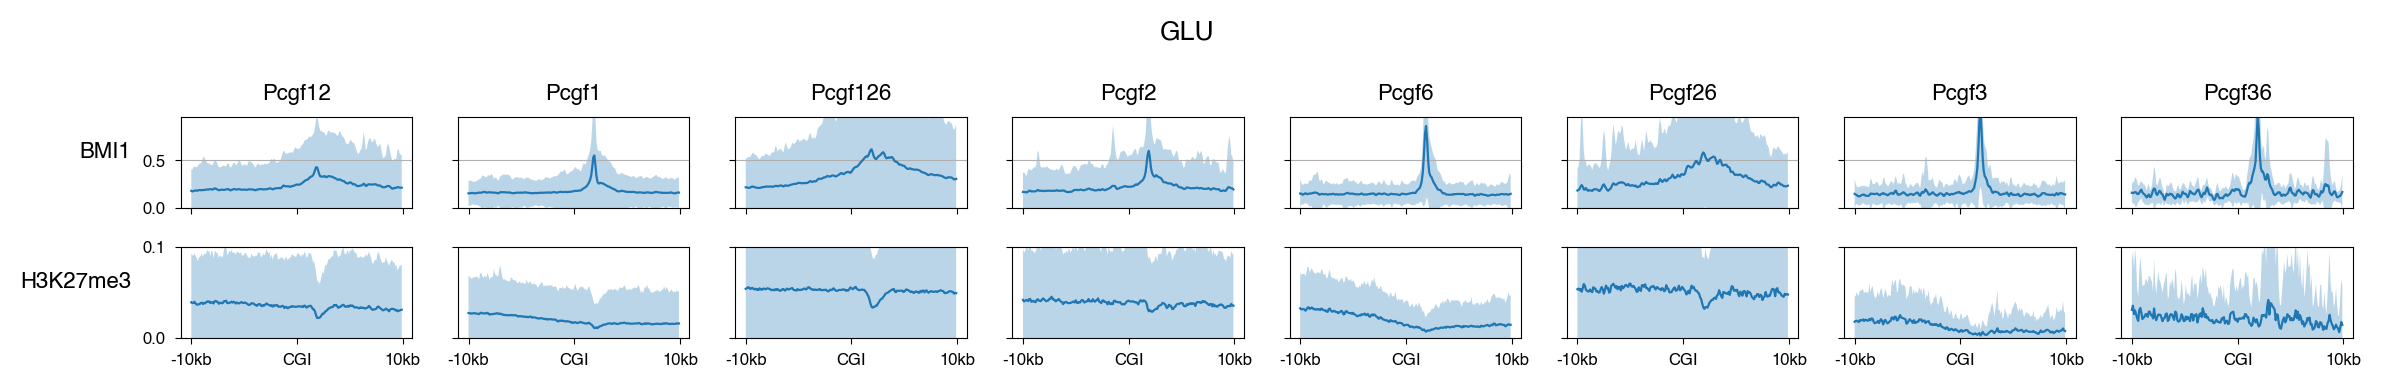

In [66]:
# plot average profiles
ct = 'GLU'
offset, nbins = 10_000, 200

prof_paths = {
    "BMI1": "/tank/projects/rina/tian23/new_bmi/new_bmi_result/bwa/merged_library/bigwig/BMI1_NEUN_DLPFC_merged.bigWig",
    "H3K27me3": f"/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/{ct}.merged.bigWig",
    # "ATAC-seq": "/media/backup2/PsychEncode/BrainTF/ATAC-seq/1224_1230_DLPFC_NeuN_basename_prefix.pooled.pval.signal.bigwig"
}

pcgf_grps = pcgf_tss['PcgfTarget'].unique()

# me3_grps = {
#     'dot anchor + bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & cgi['near_anch'] & cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
#     'only bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & ~cgi['near_anch'] & cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
#     'no bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & ~cgi['near_anch'] & ~cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
# }
# grp_color = ['red', 'lightcoral', 'grey']

fig, axs = plt.subplots(len(prof_paths), len(pcgf_grps), dpi=200, 
                        figsize=[1.5 * len(pcgf_grps), 0.7 * len(prof_paths) + 0.5], 
                        sharey='row', sharex=True)

for j, grp_name in enumerate(pcgf_grps):
    plot_df = pcgf_tss.loc[pcgf_tss['PcgfTarget'] == grp_name].copy(deep=True).reset_index()
    # plot_df.loc[:, 'mid'] = (plot_df['start'] + plot_df['end']) / 2
    plot_df.loc[:, 'start'] -= offset
    plot_df.loc[:, 'end'] += offset
    flip_idx = plot_df.loc[plot_df['strand'] == '-'].index
    
    for i, (prof, path) in enumerate(prof_paths.items()):
        s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], 
                        bins=nbins)
        if len(flip_idx) > 0:
            s[flip_idx, :] = np.fliplr(s[flip_idx, :])
        s_mean = np.nanmean(s, axis=0)
        s_std = np.nanstd(s, axis=0)

        ax = axs[i, j] 
        ax.plot(s_mean, linewidth=0.8, 
                # c=grp_color[j]
               )
        ax.fill_between(np.arange(nbins), s_mean-s_std, s_mean+s_std, 
                        alpha=0.3, 
                        # color=grp_color[j]
                       )
        # ax.fill_between(np.arange(nbins), [0]*nbins, np.mean(s, axis=0))

        ax.set_xticks([0, nbins//2, nbins], [f"{-offset//1000}kb", 'CGI', f"{offset//1000}kb"])
        ax.grid(axis='y', which='both', linewidth=0.4)

        if j == 0:
            ax.set_ylim([0, (s_mean+s_std).max()])
            ax.set_ylabel(prof, rotation='horizontal', ha='right')
        if i == 0:
            ax.set_title(grp_name)

plt.suptitle(ct)
plt.tight_layout()

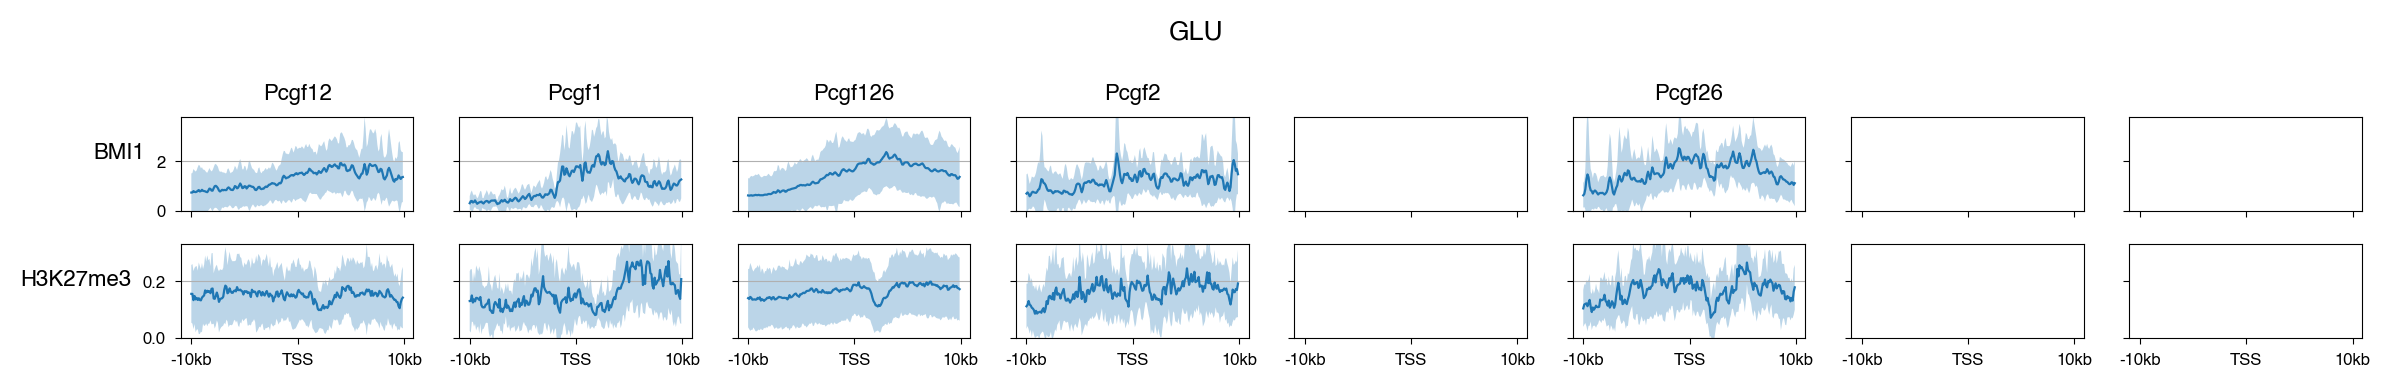

In [69]:
# plot average profiles
ct = 'GLU'
offset, nbins = 10_000, 200

prof_paths = {
    "BMI1": "/tank/projects/rina/tian23/new_bmi/new_bmi_result/bwa/merged_library/bigwig/BMI1_NEUN_DLPFC_merged.bigWig",
    "H3K27me3": f"/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/{ct}.merged.bigWig",
    # "ATAC-seq": "/media/backup2/PsychEncode/BrainTF/ATAC-seq/1224_1230_DLPFC_NeuN_basename_prefix.pooled.pval.signal.bigwig"
}

pcgf_grps = pcgf_tss['PcgfTarget'].unique()

# me3_grps = {
#     'dot anchor + bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & cgi['near_anch'] & cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
#     'only bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & ~cgi['near_anch'] & cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
#     'no bmi1': cgi.loc[cgi[f"near_me3_{ct}"] & ~cgi['near_anch'] & ~cgi['near_bmi1'] & ~cgi[f'near_expr_{ct}']],
# }
# grp_color = ['red', 'lightcoral', 'grey']

fig, axs = plt.subplots(len(prof_paths), len(pcgf_grps), dpi=200, 
                        figsize=[1.5 * len(pcgf_grps), 0.7 * len(prof_paths) + 0.5], 
                        sharey='row', sharex=True)

for j, grp_name in enumerate(pcgf_grps):
    plot_df = pcgf_tss.loc[(pcgf_tss['PcgfTarget'] == grp_name) & (pcgf_tss['gene.name'].isin(hand_genes_all))].copy(deep=True).reset_index()
    if plot_df.shape[0] == 0:
        continue
    # plot_df.loc[:, 'mid'] = (plot_df['start'] + plot_df['end']) / 2
    plot_df.loc[:, 'start'] -= offset
    plot_df.loc[:, 'end'] += offset
    flip_idx = plot_df.loc[plot_df['strand'] == '-'].index
    
    for i, (prof, path) in enumerate(prof_paths.items()):
        s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], 
                        bins=nbins)
        if len(flip_idx) > 0:
            s[flip_idx, :] = np.fliplr(s[flip_idx, :])
        s_mean = np.nanmean(s, axis=0)
        s_std = np.nanstd(s, axis=0)

        ax = axs[i, j] 
        ax.plot(s_mean, linewidth=0.8, 
                # c=grp_color[j]
               )
        ax.fill_between(np.arange(nbins), s_mean-s_std, s_mean+s_std, 
                        alpha=0.3, 
                        # color=grp_color[j]
                       )
        # ax.fill_between(np.arange(nbins), [0]*nbins, np.mean(s, axis=0))

        ax.set_xticks([0, nbins//2, nbins], [f"{-offset//1000}kb", 'TSS', f"{offset//1000}kb"])
        ax.grid(axis='y', which='both', linewidth=0.4)

        if j == 0:
            ax.set_ylim([0, (s_mean+s_std).max()])
            ax.set_ylabel(prof, rotation='horizontal', ha='right')
        if i == 0:
            ax.set_title(grp_name)

plt.suptitle(ct)
plt.tight_layout()

## How many anchors overlap CGI

In [42]:
# hand_anch_wide = bf.expand(hand_anch, 10000)
hand_olap = bf.overlap(hand_anch, cgi, how='inner', suffixes=['', '_cgi'], return_index=True)\
    .drop_duplicates(['chrom', 'start', 'end'])
print(
    hand_olap.shape[0],
    hand_anch.shape[0],
    hand_olap.shape[0] / hand_anch.shape[0]
)

248 262 0.9465648854961832


In [40]:
hand_anch.loc[~hand_anch.index.isin(hand_olap['index'])]

,chrom,start,end,genes
20,chr1,229490000,229500000,NUP133
32,chr10,118230000,118240000,AL354863.1
46,chr12,65810000,65820000,"HMGA2,RPSAP52"
51,chr12,115740000,115760000,AC009387.1
54,chr13,27370000,27380000,LINC01079
70,chr14,61260000,61270000,"TMEM30B,PRKCH"
109,chr2,170350000,170360000,"MYO3B,AC012594.1"
151,chr4,111620000,111630000,AC083795.2
165,chr5,77960000,77970000,AC108482.1
201,chr6,125730000,125740000,"HEY2, AL365259.1"


## How many anchors overlap ATAC-seq

In [149]:
bf.overlap(hand_anch, atac_peak, how='inner', suffixes=['', '_atac'], return_index=True)\
    .drop_duplicates(['chrom', 'start', 'end'])

,index,chrom,start,end,genes,index_atac,chrom_atac,start_atac,end_atac,name_atac,score_atac,strand_atac,fc_atac,-log10p_atac,-log10q_atac,relSummit_atac
0,187,chr6,1360000,1410000,FOXF2,35799,chr6,1381389,1382417,.,1000,.,6.34896,44.36093,41.66628,611
2,189,chr6,5990000,6010000,NRN1,52546,chr6,5995990,5996618,.,810,.,3.23420,32.30383,29.79409,320
14,190,chr6,10370000,10420000,"TFAP2A,TFAP2A-AS1,TFAP2A-AS2",41231,chr6,10403791,10404890,.,686,.,5.42067,39.76577,37.13790,434
16,191,chr6,26230000,26330000,"HIST1H1D,HIST1H4F,HIST1H4G,HIST1H3F,HIST1H2BH,...",48417,chr6,26240001,26241205,.,1000,.,5.52974,34.67089,32.12159,698
39,193,chr6,27500000,27570000,"HNRNPA1P1,CD83P1",4716,chr6,27518391,27519673,.,1000,.,10.40106,153.12038,149.48909,841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,220,chr7,96980000,97040000,"DLX5,DLX6,DLX6-AS1",49088,chr7,97005303,97005776,.,943,.,3.70916,34.28073,31.73802,142
384,79,chr15,36870000,36940000,AC018563.1,46380,chr15,36883717,36884355,.,1000,.,4.93378,36.01952,33.44903,140
385,80,chr15,37060000,37130000,"MEIS2,AC078909.1,AC078909.2",52104,chr15,37100252,37102274,.,879,.,3.20421,32.51494,30.00126,1513
393,81,chr15,52770000,52820000,ONECUT1,41305,chr15,52780269,52781225,.,1000,.,5.91597,39.70419,37.07720,420


# CGI merged

In [40]:
# Load CGI
# cgi_path = "/tank/projects/schizophrenia_2021/data/cpgIslandExt.hg38.flt.bed.gz"
# cgi = bf.read_table(cgi_path, schema='bed3')
cgi_path = "/tank/projects/polycomb/results/2025.04.10/CpG_filtered.from_rina.bed.gz"
cgi_mrg = pd.read_table(cgi_path)

# Drop bad chromosomes
cgi_mrg = cgi_mrg.loc[cgi_mrg['chrom'].str.contains("^chr[0-9,X]*$")]

cgi_mrg = bf.merge(cgi_mrg, 5_000)
# cgi_mrg = bf.merge(cgi_mrg, 10_000)
cgi_mrg['length'] = cgi_mrg['end'] - cgi_mrg['start']

print(cgi_mrg.shape[0])
cgi_mrg.head()

18428


,chrom,start,end,n_intervals,length
0,chr1,919385,926252,2,6867
1,chr1,933952,942983,4,9031
2,chr1,950976,951222,1,246
3,chr1,958933,984547,4,25614
4,chr1,998007,1002030,1,4023


<Axes: xlabel='length', ylabel='Count'>

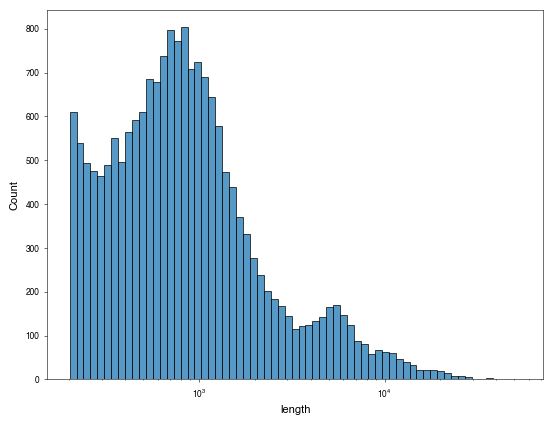

In [41]:
sns.histplot(cgi_mrg['length'], log_scale=True)

In [43]:
# Overlap with features
def add_feature(cgi_df, feature_df, col_name):
    cgi_olap = bf.overlap(cgi_df, feature_df, how='inner', return_index=True)\
        .drop_duplicates(['chrom', 'start', 'end'])

    # Write info to cgi table
    cgi_df[col_name] = False
    cgi_df.loc[cgi_olap['index'], col_name] = True
    return


# Cell type-specific features
for ct in ['GLU', 'GABA']:
    # Gene expression
    expr_gene_ct = koz_cnts.loc[koz_cnts[f'log2TPM_pl_1_{ct}'] > 0.5]
    add_feature(cgi_mrg, expr_gene_ct, f'near_expr_{ct}')

    # H3K27me3
    add_feature(cgi_mrg, bf.expand(me3_ct[ct], 1000), f'near_me3_{ct}')

# BMI1
add_feature(cgi_mrg, bmi_peak, 'near_bmi1')

# ATAC-seq
add_feature(cgi_mrg, atac_peak, 'near_atac')

# Dot anchors
add_feature(cgi_mrg, hand_anch, 'near_anch')

In [21]:
cgi_mrg.loc[cgi_mrg['near_anch'], ['near_me3_GLU', 'near_bmi1', 'near_expr_GLU']].value_counts()

near_me3_GLU  near_bmi1  near_expr_GLU
True          True       False            272
                         True              97
False         True       True              31
                         False             10
True          False      False              9
False         False      False              5
                         True               3
True          False      True               2
Name: count, dtype: int64

In [22]:
cgi_mrg.loc[cgi_mrg['near_anch'] & 
            cgi_mrg['near_me3_GLU'] & 
            cgi_mrg['near_bmi1'] & 
            cgi_mrg['near_expr_GLU']]

,chrom,start,end,n_intervals,length,near_expr_GLU,near_me3_GLU,near_expr_GABA,near_me3_GABA,near_bmi1,near_atac,near_anch
722,chr1,44417464,44418232,1,768,True,True,True,True,True,False,True
954,chr1,90835422,90836334,1,912,True,True,True,True,True,False,True
1543,chr1,213979871,213989394,5,9523,True,True,True,True,True,True,True
1568,chr1,220877106,220895817,9,18711,True,True,True,True,True,False,True
1898,chr10,22334421,22345933,3,11512,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
16827,chr8,98972356,98974755,2,2399,True,True,True,True,True,False,True
17122,chr9,21965097,21975307,4,10210,True,True,True,True,True,False,True
17124,chr9,22005888,22009472,2,3584,True,True,True,True,True,True,True
17488,chr9,122213474,122228807,4,15333,True,True,True,False,True,False,True


In [23]:
koz_cnts.loc[koz_cnts['gene.name'] == 'RNF220']

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG
16338,ENSG00000187147,chr1,44403193,44653724,RNF220,protein_coding,+,1.470845,1.578936,4.935071


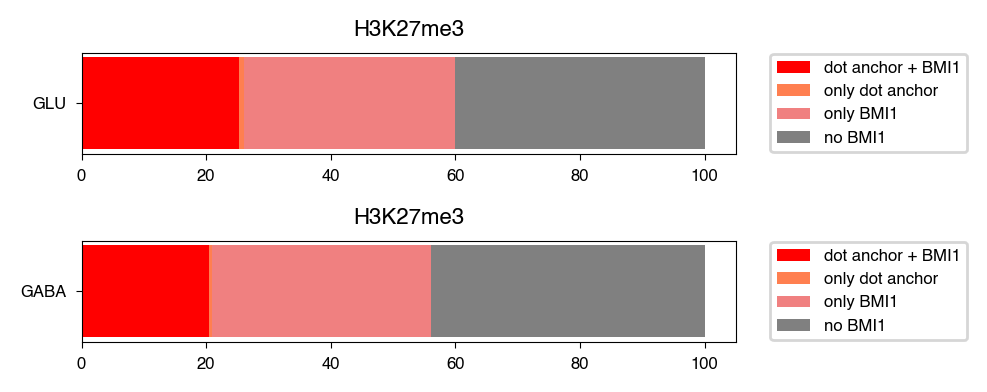

In [24]:
fig, axs = plt.subplots(2, 1, figsize=[5, 2], dpi=200)
for i, ct in enumerate(['GLU', 'GABA']):
    plot_df = cgi_mrg.loc[cgi_mrg[f'near_me3_{ct}'] & ~cgi_mrg[f'near_expr_{ct}']]
    # plot_df = cgi_mrg.loc[cgi_mrg[f'near_me3_{ct}']]
    n_plot_df = plot_df.shape[0]

    n_anch_bmi = plot_df.loc[plot_df[f'near_anch'] & plot_df[f'near_bmi1']].shape[0] / n_plot_df * 100
    n_anch = plot_df.loc[plot_df[f'near_anch'] & ~plot_df[f'near_bmi1']].shape[0] / n_plot_df * 100
    n_bmi = plot_df.loc[~plot_df[f'near_anch'] & plot_df[f'near_bmi1']].shape[0] / n_plot_df * 100
    
    bars = [n_anch_bmi, n_anch, n_bmi, 100 - n_anch - n_anch_bmi - n_bmi]
    labs = ['dot anchor + BMI1', 'only dot anchor', 'only BMI1', 'no BMI1']
    cols = ['red', 'coral', 'lightcoral', 'grey']
    left=0
    
    # plt.figure(figsize=[4, 0.5], dpi=200)
    ax = axs[i]
    for bar, col, lab in zip(bars, cols, labs):
        ax.barh(0, bar, left=left, color=col, label=lab)
        left+=bar
    
    ax.set_title("H3K27me3")
    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
    ax.set_yticks([0], [ct])

plt.tight_layout()

polycomb interaction requires both PRC1 (BMI1) and PRC2 (H3K27me3)

- Why BMI1 is not bound everythere? **Weak H3K27me3 signal**
- Why some BMI1 do not form polycomb dots? **Weak BMI1 signal**

(plot average H3K27me3, BMI1, and ATAC-seq profiles for 3 groups)

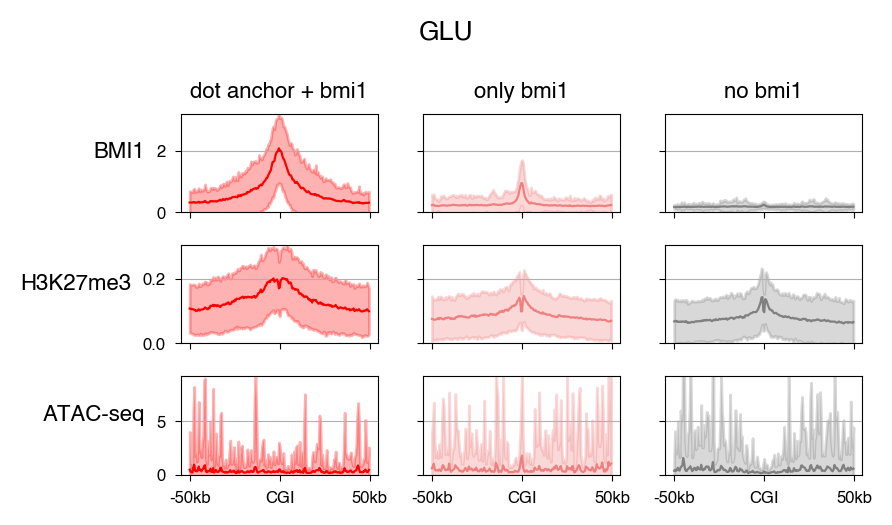

In [28]:
# plot average profiles
ct = 'GLU'
offset, nbins = 50_000, 200
# offset, nbins = 10_000, 200

prof_paths = {
    "BMI1": "/tank/projects/rina/tian23/new_bmi/new_bmi_result/bwa/merged_library/bigwig/BMI1_NEUN_DLPFC_merged.bigWig",
    "H3K27me3": f"/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/{ct}.merged.bigWig",
    "ATAC-seq": "/media/backup2/PsychEncode/BrainTF/ATAC-seq/1224_1230_DLPFC_NeuN_basename_prefix.pooled.pval.signal.bigwig",
    # "BHLHE40": "/media/backup2/PsychEncode/BrainTF/processed/BHLHE40_DLPFC-NeuN_Output_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    # "Pol2": "/media/backup2/PsychEncode/BrainTF/processed/Pol2_DLPFC-NeuN_Output_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    # "CTCF": "/media/backup2/PsychEncode/BrainTF/processed/CTCF_DLPFC-NEUN_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    # "CREM": "/media/backup2/PsychEncode/BrainTF/processed/CREM_DLPFC-NEUN_Output_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    # "DNAm_GLU": "/tank/projects/polycomb/data/heffel/methylation/bigwig/allc_adult_Exc-L6-ASTN1_pseudobulk_final.CGN-both.frac.bw"
}

me3_grps = {
    'dot anchor + bmi1': cgi_mrg.loc[cgi_mrg[f"near_me3_{ct}"] & cgi_mrg['near_anch'] & cgi_mrg['near_bmi1'] & ~cgi_mrg[f'near_expr_{ct}']],
    'only bmi1': cgi_mrg.loc[cgi_mrg[f"near_me3_{ct}"] & ~cgi_mrg['near_anch'] & cgi_mrg['near_bmi1'] & ~cgi_mrg[f'near_expr_{ct}']],
    'no bmi1': cgi_mrg.loc[cgi_mrg[f"near_me3_{ct}"] & ~cgi_mrg['near_anch'] & ~cgi_mrg['near_bmi1'] & ~cgi_mrg[f'near_expr_{ct}']],
}
# me3_grps = {
#     'dot anchor + bmi1': cgi_mrg.loc[cgi_mrg[f"near_me3_{ct}"] & cgi_mrg['near_anch'] & cgi_mrg['near_bmi1']],
#     'only bmi1': cgi_mrg.loc[cgi_mrg[f"near_me3_{ct}"] & ~cgi_mrg['near_anch'] & cgi_mrg['near_bmi1']],
#     'no bmi1': cgi_mrg.loc[cgi_mrg[f"near_me3_{ct}"] & ~cgi_mrg['near_anch'] & ~cgi_mrg['near_bmi1']],
# }
grp_color = ['red', 'lightcoral', 'grey']

fig, axs = plt.subplots(len(prof_paths), len(me3_grps), dpi=200, 
                        figsize=[1.5 * len(me3_grps), 0.7 * len(prof_paths) + 0.5], 
                        sharey='row', sharex=True)

for j, (grp_name, grp_df) in enumerate(me3_grps.items()):
    plot_df = grp_df.copy(deep=True)
    plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
    plot_df['start'] = plot_df['mid'] - offset
    plot_df['end'] = plot_df['mid'] + offset
    
    for i, (prof, path) in enumerate(prof_paths.items()):
        s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], 
                        bins=nbins)
        s_mean = np.nanmean(s, axis=0)
        s_std = np.nanstd(s, axis=0)

        ax = axs[i, j] 
        ax.plot(s_mean, linewidth=0.8, c=grp_color[j])
        ax.fill_between(np.arange(nbins), s_mean-s_std, s_mean+s_std, 
                        alpha=0.3, color=grp_color[j])
        # ax.fill_between(np.arange(nbins), [0]*nbins, np.mean(s, axis=0))

        ax.set_xticks([0, nbins//2, nbins], [f"{-offset//1000}kb", 'CGI', f"{offset//1000}kb"])
        ax.grid(axis='y', which='both', linewidth=0.4)

        if j == 0:
            ax.set_ylim([0, (s_mean+s_std).max()])
            ax.set_ylabel(prof, rotation='horizontal', ha='right')
        if i == 0:
            ax.set_title(grp_name)

plt.suptitle(ct)
plt.tight_layout()

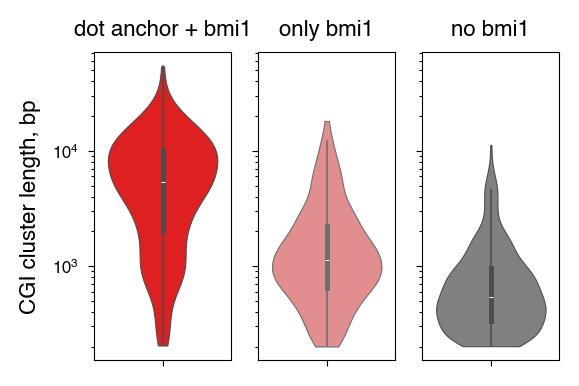

In [29]:
fig, axs = plt.subplots(1, 3, figsize=[3, 2], dpi=200, sharey=True)
grp_color = ['red', 'lightcoral', 'grey']

for i, (grp_name, grp_df) in enumerate(me3_grps.items()):
    ax = axs[i]
    # sns.boxplot(data=grp_df, y='length', ax=ax, linewidth=0.4, 
    #                showfliers=False, color=grp_color[i])
    sns.violinplot(data=grp_df, y='length', ax=ax, linewidth=0.4, color=grp_color[i], cut=0, log_scale=[False, 10])
    ax.set_title(grp_name)
    ax.set_ylabel('CGI cluster length, bp')

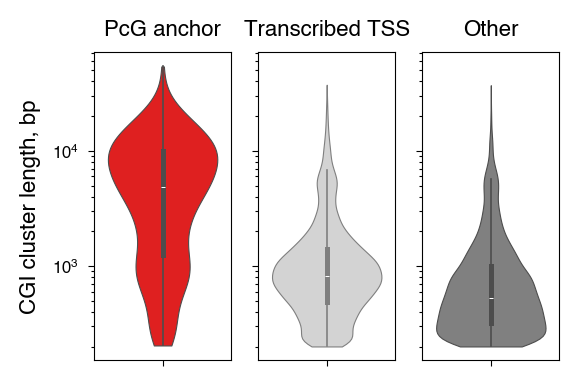

In [50]:
fig, axs = plt.subplots(1, 3, figsize=[3, 2], dpi=200, sharey=True)
grp_color = ['red', 'lightgrey', 'grey']

me3_grps = {
    'PcG anchor': cgi_mrg.loc[cgi_mrg['near_anch']],
    'Transcribed TSS': cgi_mrg.loc[~cgi_mrg['near_anch'] & cgi_mrg[f'near_expr_{ct}']],
    'Other': cgi_mrg.loc[~cgi_mrg['near_anch'] & ~cgi_mrg[f'near_expr_{ct}']],
}

for i, (grp_name, grp_df) in enumerate(me3_grps.items()):
    ax = axs[i]
    # sns.boxplot(data=grp_df, y='length', ax=ax, linewidth=0.4, 
    #                showfliers=False, color=grp_color[i])
    sns.violinplot(data=grp_df, y='length', ax=ax, linewidth=0.4, color=grp_color[i], cut=0, log_scale=[False, 10])
    ax.set_title(grp_name)
    ax.set_ylabel('CGI cluster length, bp')

# plt.savefig("CGI_cluster_length.pdf", bbox_inches='tight')

In [49]:
me3_grps['PcG anchor']['length'].median()

4827.0

In [221]:
me3_grps['dot anchor + bmi1'].sort_values('length').head(40)

,chrom,start,end,n_intervals,length,near_expr_GLU,near_me3_GLU,near_expr_GABA,near_me3_GABA,near_bmi1,near_atac,near_anch
13121,chr6,106086261,106086510,1,249,True,True,True,False,True,False,True
3486,chr12,54125984,54126673,1,689,True,True,True,True,True,False,True
8743,chr2,118224193,118224890,1,697,False,True,False,True,True,False,True
12062,chr5,43017866,43018566,1,700,True,True,True,True,True,False,True
14393,chr8,23726473,23727248,1,775,False,True,False,True,True,False,True
808,chr1,90835422,90836334,1,912,True,True,True,True,True,False,True
4526,chr14,60485258,60486228,1,970,False,True,False,True,True,False,True
3485,chr12,54106343,54107374,1,1031,False,True,False,True,True,False,True
8551,chr2,70887603,70889282,2,1679,False,True,False,True,True,False,True
3989,chr13,20192069,20193770,1,1701,False,True,False,True,True,False,True


Text(405.7777055488537, 0.5, 'CGI cluster length, bp')

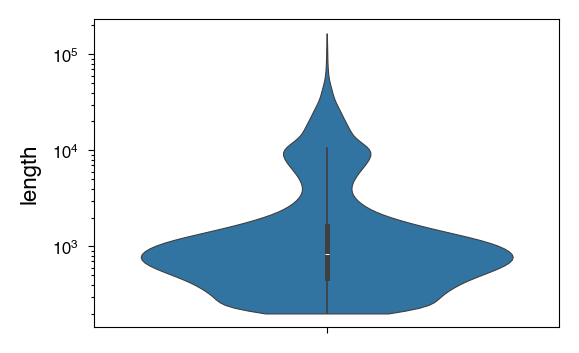

In [159]:
fig, axs = plt.subplots(1, 1, figsize=[3, 2], dpi=200, sharey=True)

sns.violinplot(data=cgi_mrg, y='length', linewidth=0.4, cut=0, log_scale=[False, 10])
ax.set_ylabel('CGI cluster length, bp')

<Axes: xlabel='length', ylabel='length_gene'>

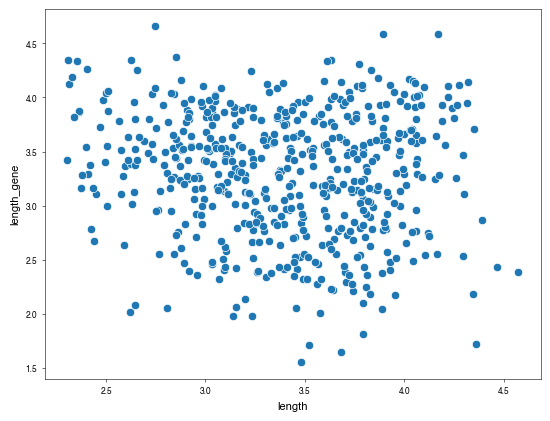

In [71]:
plot_df = me3_grps['Only BMI1']
cgi_me3_corr = bf.overlap(plot_df, me3_ct[ct], how='inner', suffixes=['', '_me3'])
cgi_me3_corr['length_gene'] = np.log10(cgi_me3_corr['end_me3'] - cgi_me3_corr['start_me3'] + 1)
cgi_me3_corr = cgi_me3_corr.groupby(['chrom', 'start', 'end'], as_index=False)['length_gene'].max()
cgi_me3_corr['length'] = np.log10(cgi_me3_corr['end'] - cgi_me3_corr['start'] + 1)
sns.scatterplot(data=cgi_me3_corr, x=cgi_me3_corr['length'], y=cgi_me3_corr['length_gene'])

In [75]:
koz_cnts.loc[koz_cnts['gene.name'].str.contains('PCGF')]

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG
4391,ENSG00000115289,chr2,74503042,74509695,PCGF1,protein_coding,-,4.764241,4.729853,4.985268
9946,ENSG00000156374,chr10,103300795,103353144,PCGF6,protein_coding,-,1.976220,1.924344,1.711309
14842,ENSG00000180628,chr10,91161011,91286337,PCGF5,protein_coding,+,2.745136,3.518604,3.613501
15949,ENSG00000185619,chr4,703747,772089,PCGF3,protein_coding,+,3.197495,3.487800,4.082947
37982,ENSG00000249592,chr4,758201,783866,PCGF3-AS1,lncRNA,-,4.696863,5.211552,6.198746
49115,ENSG00000268140,chr19,22135930,22140981,PCGF7P,processed_pseudogene,+,0.000000,0.207364,0.000000
53540,ENSG00000277258,chr17,38731897,38751817,PCGF2,protein_coding,-,0.000000,0.014648,0.000000


In [77]:
koz_cnts.loc[koz_cnts['gene.name'].str.contains('BMI')]

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG
12293,ENSG00000168283,chr10,22319098,22333484,BMI1,protein_coding,+,5.159075,4.983817,6.419593
31602,ENSG00000234201,chrX,67789954,67794895,BMI1P1,processed_pseudogene,-,0.914464,0.000000,0.831169
49668,ENSG00000269897,chr10,22314387,22331542,COMMD3-BMI1,protein_coding,+,0.036072,0.017708,0.290341


In [76]:
koz_cnts.loc[koz_cnts['gene.name'].str.contains('KDM2B')]

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG
1812,ENSG00000089094,chr12,121427095,121583023,KDM2B,protein_coding,-,1.906538,2.253471,2.499368
42878,ENSG00000256742,chr12,121578791,121595504,KDM2B-DT,lncRNA,+,1.845459,2.351082,2.307542


<Axes: xlabel='length', ylabel='length_gene'>

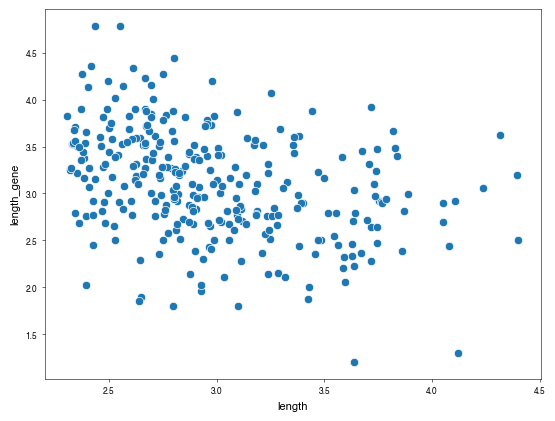

In [72]:
plot_df = me3_grps['No BMI1']
cgi_me3_corr = bf.overlap(plot_df, me3_ct[ct], how='inner', suffixes=['', '_me3'])
cgi_me3_corr['length_gene'] = np.log10(cgi_me3_corr['end_me3'] - cgi_me3_corr['start_me3'] + 1)
cgi_me3_corr = cgi_me3_corr.groupby(['chrom', 'start', 'end'], as_index=False)['length_gene'].max()
cgi_me3_corr['length'] = np.log10(cgi_me3_corr['end'] - cgi_me3_corr['start'] + 1)
sns.scatterplot(data=cgi_me3_corr, x=cgi_me3_corr['length'], y=cgi_me3_corr['length_gene'])

PRC1/2 signal intensity is defined by CGI length

## How many anchors overlap CGI

In [81]:
hand_anch_wide = bf.expand(hand_anch, 10000)
bf.overlap(hand_anch_wide, cgi_mrg, how='inner', suffixes=['', '_cgi'])\
    .drop_duplicates(['chrom', 'start', 'end'])

,chrom,start,end,genes,chrom_cgi,start_cgi,end_cgi,n_intervals_cgi,length_cgi,near_expr_GLU_cgi,near_me3_GLU_cgi,near_expr_GABA_cgi,near_me3_GABA_cgi,near_bmi1_cgi,near_atac_cgi,near_anch_cgi
0,chr6,1350000,1420000,FOXF2,chr6,1378210,1393935,5,15725,True,True,False,True,True,True,True
1,chr6,1580000,1640000,FOXC1,chr6,1598855,1625233,6,26378,True,True,True,True,True,False,True
2,chr6,5980000,6020000,NRN1,chr6,5994676,6009364,8,14688,True,False,True,True,True,True,True
3,chr6,10360000,10430000,"TFAP2A,TFAP2A-AS1,TFAP2A-AS2",chr6,10381325,10390865,5,9540,False,True,False,True,True,False,True
5,chr6,26220000,26340000,"HIST1H1D,HIST1H4F,HIST1H4G,HIST1H3F,HIST1H2BH,...",chr6,26225158,26225562,1,404,True,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,chr12,27770000,27790000,GSX1,chr12,27779818,27780805,1,987,True,False,True,False,False,True,True
367,chr12,113450000,113470000,"LHX5,LHX5-AS1",chr12,113462945,113480302,5,17357,False,True,False,True,True,False,False
368,chr12,114380000,114400000,"TBX5,TBX5-AS1",chr12,114396106,114414555,6,18449,False,True,False,True,True,False,False
369,chr12,114670000,114690000,TBX3,chr12,114682969,114692437,3,9468,False,True,False,True,True,False,False


In [82]:
hand_anch.shape

(241, 4)

## Overlap CGI with polycomb anchors and BMI1 peaks

In [183]:
# Overlap CGI with polycomb anchors and BMI1 peaks
cgi_at_anch = bf.overlap(cgi_mrg, hand_anch, how='inner', suffixes=['', '_anch'])\
    .drop_duplicates(['chrom', 'start', 'end'])
print(cgi_at_anch.shape[0])
cgi_at_anch.head()

273


,chrom,start,end,n_intervals,length,chrom_anch,start_anch,end_anch,genes_anch
0,chr10,8049411,8058805,2,9394,chr10,8050000,8050000,"GATA3,GATA3-AS1"
1,chr10,100724023,100749889,8,25866,chr10,100730000,100730000,PAX2
2,chr10,101213743,101230435,3,16692,chr10,101220000,101220000,"LBX1,LBX1-AS1"
3,chr10,129958426,129973432,2,15006,chr10,129960000,129960000,EBF3
4,chr18,904577,909573,2,4996,chr18,900000,915000,"ADCYAP1,AP000894.2"


In [184]:
cgi_at_anch['length'] = cgi_at_anch['end'] - cgi_at_anch['start']
cgi_at_anch['length'].describe()

count      273.000000
mean      6970.560440
std       7066.046402
min        205.000000
25%       1355.000000
50%       5348.000000
75%      10210.000000
max      54035.000000
Name: length, dtype: float64

In [185]:
# Overlap resulting CGI with NeuN BMI1 peaks
# bmi_peak_path = "/media/backup2/PsychEncode/BrainTF/processed/BMI1_DLPFC-NeuN_Output_idr.optimal_peak.regionPeak.gz"
bmi_peak_path = "/tank/projects/rina/tian23/new_bmi/new_bmi_result/bwa/merged_library/macs3/narrow_peak/BMI1_NEUN_merged_peaks.narrowPeak"
bmi_peak = bf.read_table(bmi_peak_path, schema='narrowPeak')

cgi_at_anch_bmi = bf.overlap(cgi_at_anch, bmi_peak, how='inner', 
                             return_overlap=True, suffixes=['', '_bmi1'])
print(cgi_at_anch_bmi.shape[0])

# Merge overlapping
cgi_at_anch_bmi = bf.merge(cgi_at_anch_bmi, cols=['chrom', 'overlap_start', 'overlap_end'])
print(cgi_at_anch_bmi.shape[0])

# Save result
# cgi_at_anch_bmi[['chrom', 'overlap_start', 'overlap_end']]\
#     .to_csv("cgi_at_dot_anch_and_bmi1_peaks.bed", sep='\t', index=False, header=False)

cgi_at_anch_bmi.head()

569
569


,chrom,overlap_start,overlap_end,n_intervals
0,chr1,18630401,18642079,1
1,chr1,18642176,18646866,1
2,chr1,18647129,18647239,1
3,chr1,24929036,24929742,1
4,chr1,24930250,24932514,1


## Find CGI near transcribed genes

In [186]:
tpm_path = "/tank/projects/schizophrenia_2021/data/kozlenkov2018/RNA-seq/kozlenkov.logTPM_counts.csv.gz"
koz_cnts = pd.read_table(tpm_path, sep=',')

koz_cnts = bf.expand(koz_cnts, 2000)

for ct in ['GLU', 'GABA']:
    expr_gene_ct = koz_cnts.loc[koz_cnts[f'log2TPM_pl_1_{ct}'] > 1]
    cgi_gene = bf.overlap(cgi_mrg, expr_gene_ct, how='inner', return_index=True)\
        .drop_duplicates(['chrom', 'start', 'end'])

    # Write info to cgi table
    cgi_mrg[f'near_expr_{ct}'] = False
    cgi_mrg.loc[cgi_gene['index'], f'near_expr_{ct}'] = True
    
koz_cnts.head()

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG
0,ENSG00000000003,chrX,100625107,100641991,TSPAN6,protein_coding,-,1.358388,1.575157,2.075568
1,ENSG00000000005,chrX,100582935,100601885,TNMD,protein_coding,+,0.195109,0.076332,0.228532
2,ENSG00000000419,chr20,50932866,50961140,DPM1,protein_coding,-,5.021609,4.870370,4.823697
3,ENSG00000000457,chr1,169847630,169896267,SCYL3,protein_coding,-,3.529446,3.306718,3.420497
4,ENSG00000000460,chr1,169660006,169856080,C1orf112,protein_coding,+,0.724213,0.829007,1.482341


In [187]:
# Find CGI overlapping BMI1
cgi_bmi = bf.overlap(cgi_mrg, bmi_peak, how='inner', 
                     return_index=True, suffixes=['', '_bmi1'])\
    .drop_duplicates(['chrom', 'start', 'end'])

# Write info to cgi table
cgi_mrg['near_bmi1'] = False
cgi_mrg.loc[cgi_bmi['index'], 'near_bmi1'] = True

print(cgi_bmi.shape[0])
cgi_bmi.head()

8692


,index,chrom,start,end,n_intervals,length,near_expr_GLU,near_expr_GABA,index_bmi1,chrom_bmi1,start_bmi1,end_bmi1,name_bmi1,score_bmi1,strand_bmi1,fc_bmi1,-log10p_bmi1,-log10q_bmi1,relSummit_bmi1
0,16420,chr8,6707793,6709137,1,1344,False,False,48128,chr8,6708039,6708421,new_bmi_result/bwa/merged_library/macs3/narrow...,154,.,7.52948,18.46010,15.44330,170
1,16422,chr8,6834311,6835613,1,1302,False,False,48129,chr8,6834391,6834742,new_bmi_result/bwa/merged_library/macs3/narrow...,42,.,4.16416,6.66674,4.23471,228
3,16427,chr8,8723041,8723704,1,663,False,False,48147,chr8,8723555,8723767,new_bmi_result/bwa/merged_library/macs3/narrow...,30,.,3.58315,5.39148,3.07365,120
4,16431,chr8,9150548,9151843,1,1295,False,False,48156,chr8,9150935,9151116,new_bmi_result/bwa/merged_library/macs3/narrow...,35,.,3.76474,5.95445,3.58116,104
5,16433,chr8,9898667,9907238,3,8571,True,True,48176,chr8,9898830,9899103,new_bmi_result/bwa/merged_library/macs3/narrow...,39,.,4.16947,6.40695,3.98815,145


In [188]:
cgi_mrg[['near_bmi1', 'near_expr_GLU', 'near_expr_GABA']].value_counts()

near_bmi1  near_expr_GLU  near_expr_GABA
True       True           True              6482
False      True           True              5797
           False          False             3166
True       False          False             1736
False      True           False              446
           False          True               327
True       True           False              261
           False          True               213
Name: count, dtype: int64

In [189]:
cgi_mrg.shape

(18428, 8)

In [190]:
# Find CGI overlapping dot anchors
cgi_anch = bf.overlap(cgi_mrg, hand_anch, how='inner', suffixes=['', '_anch'], 
                      return_index=True)\
    .drop_duplicates(['chrom', 'start', 'end'])

# Write info to cgi table
cgi_mrg['near_anch'] = False
cgi_mrg.loc[cgi_anch['index'], 'near_anch'] = True

print(cgi_anch.shape[0])
cgi_anch.head()

273


,index,chrom,start,end,n_intervals,length,near_expr_GLU,near_expr_GABA,near_bmi1,index_anch,chrom_anch,start_anch,end_anch,genes_anch
0,1837,chr10,8049411,8058805,2,9394,False,False,True,22,chr10,8050000,8050000,"GATA3,GATA3-AS1"
1,2283,chr10,100724023,100749889,8,25866,False,False,True,28,chr10,100730000,100730000,PAX2
2,2297,chr10,101213743,101230435,3,16692,False,False,True,29,chr10,101220000,101220000,"LBX1,LBX1-AS1"
3,2494,chr10,129958426,129973432,2,15006,False,False,True,34,chr10,129960000,129960000,EBF3
4,7823,chr18,904577,909573,2,4996,True,True,True,95,chr18,900000,915000,"ADCYAP1,AP000894.2"


In [14]:
# Find CGI overlapping H3K27me3

mer_dir = '/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/broadPeak/'
me3_path = {
    'EN_R1': mer_dir + 'GLU_REP1_peaks.flt.broadPeak.gz',
    'EN_R2': mer_dir + 'GLU_REP2_peaks.flt.broadPeak.gz',
    'IN_R1': mer_dir + 'GABA_REP1_peaks.flt.broadPeak.gz',
    'IN_R2': mer_dir + 'GABA_REP2_peaks.flt.broadPeak.gz',   
}
me3_reps = {rep: bf.read_table(me3_path[rep], schema='broadPeak') 
            for rep in me3_path.keys()}

In [15]:
me3_ct = {}

me3_ct['GLU'] = bf.overlap(me3_reps['EN_R1'], me3_reps['EN_R2'], how='inner', return_overlap=True)\
    .loc[:, ['chrom', 'overlap_start', 'overlap_end']]\
    .rename(columns={'overlap_start': 'start', 'overlap_end': 'end'})
me3_ct['GABA'] = bf.overlap(me3_reps['IN_R1'], me3_reps['IN_R2'], how='inner', return_overlap=True)\
    .loc[:, ['chrom', 'overlap_start', 'overlap_end']]\
    .rename(columns={'overlap_start': 'start', 'overlap_end': 'end'})
# me3 = pd.concat([me3_en, me3_in], ignore_index=True)
# me3 = bf.merge(me3)

# cgi_me3 = bf.overlap(cgi, me3, how='inner', 
#                      return_index=True, suffixes=['', '_bmi1'])\
#     .drop_duplicates(['chrom', 'start', 'end'])

for ct in ['GLU', 'GABA']:
    cgi_me3 = bf.overlap(cgi_mrg, me3_ct[ct], how='inner', return_index=True)\
        .drop_duplicates(['chrom', 'start', 'end']) 

    # Write info to cgi table
    cgi_mrg[f'near_me3_{ct}'] = False
    cgi_mrg.loc[cgi_me3['index'], f'near_me3_{ct}'] = True

print(cgi_me3.shape[0])
cgi_me3.head()

1069


,index,chrom,start,end,n_intervals,length,near_expr_GLU,near_expr_GABA,near_bmi1,near_anch,near_me3_GLU,index_,chrom_,start_,end_
0,1836,chr10,8034039,8036415,2,2376,False,False,True,False,True,189,chr10,8034247,8034637
2,1837,chr10,8049411,8058805,2,9394,False,False,True,True,True,191,chr10,8049455,8051562
5,1898,chr10,22334421,22345933,3,11512,True,True,True,False,True,508,chr10,22336719,22340503
7,1903,chr10,23191768,23199614,3,7846,True,True,True,False,True,523,chr10,23193463,23198651
8,1925,chr10,28668479,28669187,1,708,False,False,True,False,True,557,chr10,28668999,28671772


In [16]:
features = ['near_bmi1', 'near_expr_GLU', 'near_expr_GABA', 'near_me3_GLU', 
            'near_me3_GABA', 'near_anch']
cgi_mrg[features].value_counts()

near_bmi1  near_expr_GLU  near_expr_GABA  near_me3_GLU  near_me3_GABA  near_anch
True       True           True            False         False          False        6301
False      True           True            False         False          False        5747
           False          False           False         False          False        2902
True       False          False           False         False          False        1152
False      True           False           False         False          False         420
           False          True            False         False          False         320
True       False          False           True          True           False         213
           True           False           False         False          False         186
           False          True            False         False          False         174
                          False           True          True           True          156
                             

In [17]:
cgi_mrg.groupby(features)['length'].median().sort_values(ascending=False)

near_bmi1  near_expr_GLU  near_expr_GABA  near_me3_GLU  near_me3_GABA  near_anch
True       True           False           True          True           True         11301.0
                          True            True          False          True          8172.0
                                                        True           True          8083.0
False      True           False           False         True           True          7997.0
True       False          False           True          True           True          6807.0
           True           False           False         True           True          6289.0
                          True            True          False          False         6152.5
           False          True            True          True           False         6088.0
False      True           True            True          True           False         6084.5
True       True           False           True          True           False         5959.0

In [19]:
cgi_mrg.loc[(cgi_mrg['near_anch'] == True)].sort_values('length')

,chrom,start,end,n_intervals,length,near_expr_GLU,near_expr_GABA,near_bmi1,near_anch,near_me3_GLU,near_me3_GABA
14741,chr6,27291179,27291384,1,205,False,False,True,True,True,True
15102,chr6,108133856,108134069,1,213,True,True,True,True,False,False
17040,chr9,826582,826800,1,218,False,False,False,True,False,False
15194,chr6,133837988,133838211,1,223,False,False,True,True,True,True
14939,chr6,50724436,50724662,1,226,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
2283,chr10,100724023,100749889,8,25866,False,False,True,True,True,True
14594,chr6,1598855,1625233,6,26378,False,False,True,True,True,True
9870,chr2,44928056,44955972,10,27916,True,False,True,True,True,True
10420,chr2,176079359,176130829,19,51470,False,False,True,True,True,True


<Axes: xlabel='near_bmi1', ylabel='length'>

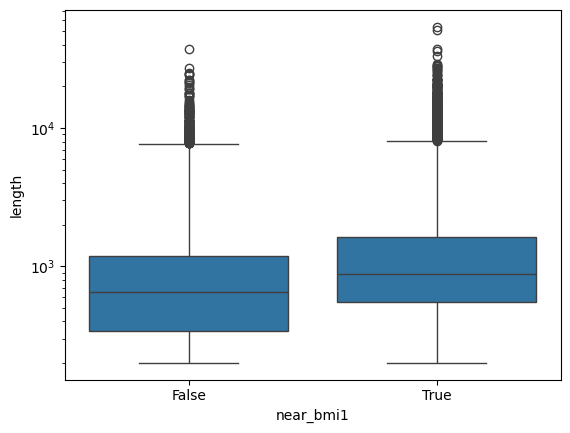

In [20]:
sns.boxplot(data=cgi_mrg, x='near_bmi1', y='length', orient='v', log_scale=True)

<Axes: xlabel='near_anch', ylabel='length'>

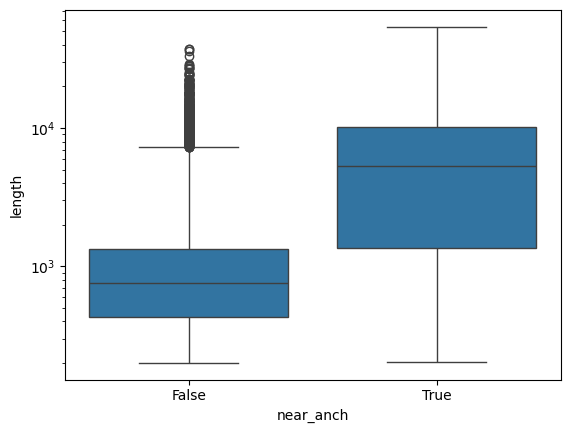

In [21]:
sns.boxplot(data=cgi_mrg, x='near_anch', y='length', orient='v', log_scale=True)

<Axes: xlabel='near_me3_GABA', ylabel='length'>

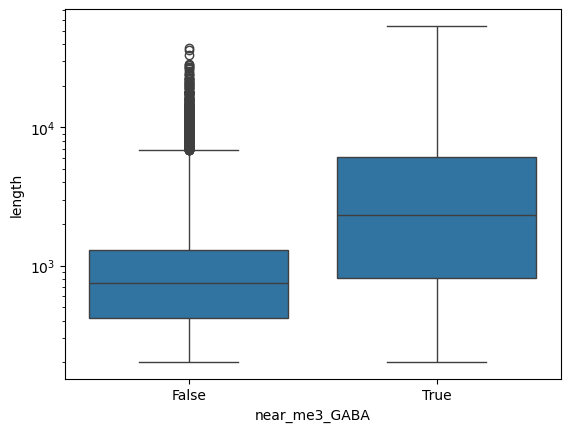

In [22]:
plot_df = cgi_mrg.copy()
sns.boxplot(data=plot_df, x='near_me3_GABA', y='length', orient='v', log_scale=True)

<Axes: xlabel='near_anch', ylabel='length'>

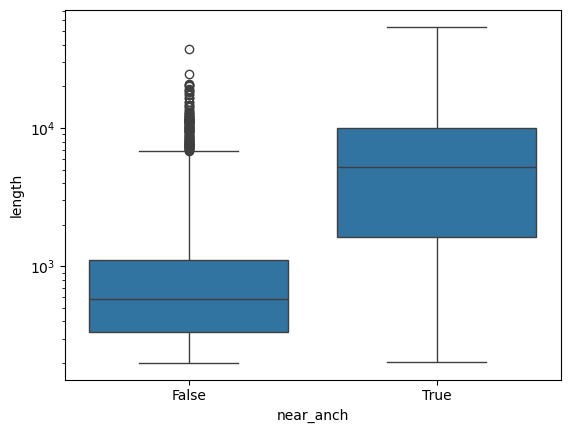

In [23]:
plot_df = cgi_mrg.loc[(cgi_mrg[['near_expr_GLU', 'near_expr_GLU']] == False).any(axis=1)]
sns.boxplot(data=plot_df, x='near_anch', y='length', orient='v', log_scale=True)

In [224]:
cgi_mrg.loc[(cgi_mrg[features] == False).all(axis=1) & (cgi_mrg['chrom'] == 'chr2')].head(40)

,chrom,start,end,n_intervals,length,near_expr_gene,near_bmi1,near_anch,near_me3,grp,near_expr_GLU,near_expr_GABA,near_me3_GLU,near_me3_GABA
9611,chr2,197437,198535,1,1098,False,False,False,False,000000,False,False,False,False
9612,chr2,214011,214245,1,234,False,False,False,False,000000,False,False,False,False
9616,chr2,314828,315170,1,342,False,False,False,False,000000,False,False,False,False
9618,chr2,426472,427581,1,1109,False,False,False,False,000000,False,False,False,False
9619,chr2,467849,468659,1,810,False,False,False,False,000000,False,False,False,False
9620,chr2,487884,488610,1,726,False,False,False,False,000000,False,False,False,False
9621,chr2,495193,497038,2,1845,False,False,False,False,000000,False,False,False,False
9622,chr2,502994,503902,2,908,False,False,False,False,000000,False,False,False,False
9623,chr2,558069,558469,1,400,False,False,False,False,000000,False,False,False,False
9624,chr2,582399,583385,2,986,False,False,False,False,000000,False,False,False,False


<Axes: xlabel='length'>

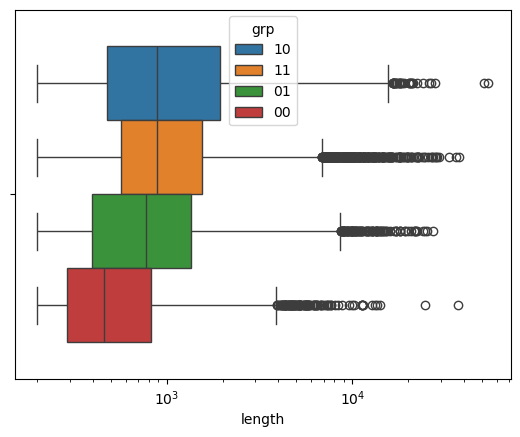

In [184]:
cgi_mrg['grp'] = cgi_mrg['near_bmi1'].astype(int).astype(str) + cgi_mrg['near_expr_gene'].astype(int).astype(str)
sns.boxplot(data=cgi_mrg, x='length', hue='grp', log_scale=True)

<Axes: xlabel='length'>

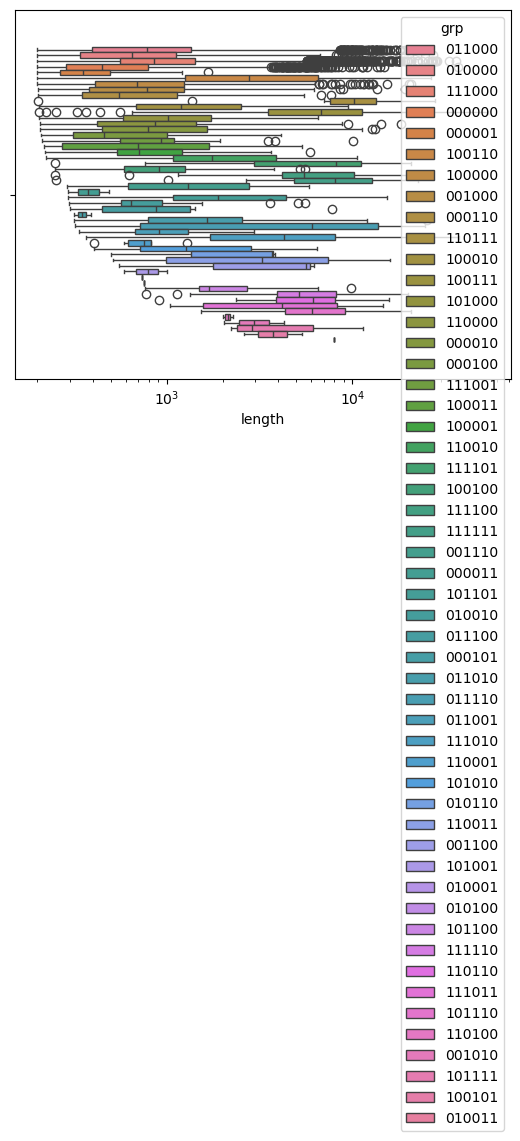

In [203]:
cgi_mrg['grp'] = cgi_mrg[features].apply(
    lambda x: ''.join(x.astype(int).astype(str)),
    axis=1
)

sns.boxplot(data=cgi.sort_values('length'), x='length', hue='grp', log_scale=True)

## Silent vs active genes

Are CGI features different in development vs neuronal repressed genes?

In [105]:
threshold = 0.075

def classify_activity(exprs):
    if all(exprs > threshold):
        return 'Active'
    elif any(exprs > threshold):
        return 'Part. active'
    else:
        return 'Non-active'

In [106]:
hand_expr_subt_path = "/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/For_paper_Nov2024start/polycombed_genes_expressions_update_MeanBy_CtReg.csv"
hand_expr_subt = pd.read_table(hand_expr_subt_path, sep=',')
hand_expr_subt.head()

,ROIGroupCoarse,Clusters,AC003986.3,AC004080.2,AC004080.4,AC004080.5,AC005224.2,AC007405.2,AC008060.2,AC008060.3,...,TBR1,LHX2,HMGA2,RPSAP52,MIR96,MIR182,AC084864.1,NR4A2,AC074099.1,RAX
0,Cerebellum,MSN-D2,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,Cerebellum,Pvalb,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.500000,0.000000,0.000000
2,Cerebellum,Sst,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,Cerebral cortex,Amy-Exc,0.00189,0.0,0.0,0.0,0.001194,0.002685,0.000398,0.000597,...,0.316391,0.886016,0.006664,0.001691,0.0,0.0,0.000099,0.120847,0.000298,0.000099
4,Cerebral cortex,Foxp2,0.00000,0.0,0.0,0.0,0.000000,0.091346,0.000000,0.000000,...,0.009615,0.004808,0.004808,0.000000,0.0,0.0,0.000000,0.072115,0.000000,0.000000


In [ ]:
hand_expr_subt.melt(id_vars=['ROIGroupCoarse', 'Clusters'])

In [52]:
hand_expr_subt.drop(columns='Clusters')\
    .melt(id_vars=['ROIGroupCoarse'])\
    .groupby(['ROIGroupCoarse'], as_index=False)['value'].mean()\
    .sort_values('value')

,ROIGroupCoarse,value
7,Pons,0.079272
6,Myelencephalon,0.093919
5,Midbrain,0.100730
0,Cerebellum,0.107724
8,Spinal cord,0.116778
3,Hippocampus,0.149223
9,Thalamus,0.167127
1,Cerebral cortex,0.178593
2,Cerebral nuclei,0.191750
4,Hypothalamus,0.263203


In [40]:
plot_df

ROIGroupCoarse
Cerebellum
Cerebral cortex
Cerebral nuclei
Hippocampus
Hypothalamus
Midbrain
Myelencephalon
Pons
Spinal cord
Thalamus


In [12]:
hand_expr_grp = hand_expr_subt\
    .loc[(hand_expr_subt['ROIGroupCoarse'] == 'Cerebral cortex') & 
         (~hand_expr_subt['Clusters'].isin(['MSN-D1', 'MSN-D2', 'Amy-Exc', 'Foxp2']))]\
    .drop(columns=['ROIGroupCoarse', 'Clusters'])\
    .apply(classify_activity, axis=0)
hand_expr_grp.head()

AC003986.3      Non-active
AC004080.2      Non-active
AC004080.4      Non-active
AC004080.5      Non-active
AC005224.2    Part. active
dtype: object

In [14]:
koz_cnts['activity'] = koz_cnts['gene.name'].map(hand_expr_grp)
koz_cnts.head()

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG,activity
0,ENSG00000000003,chrX,100625107,100641991,TSPAN6,protein_coding,-,1.358388,1.575157,2.075568,NaN
1,ENSG00000000005,chrX,100582935,100601885,TNMD,protein_coding,+,0.195109,0.076332,0.228532,NaN
2,ENSG00000000419,chr20,50932866,50961140,DPM1,protein_coding,-,5.021609,4.870370,4.823697,NaN
3,ENSG00000000457,chr1,169847630,169896267,SCYL3,protein_coding,-,3.529446,3.306718,3.420497,NaN
4,ENSG00000000460,chr1,169660006,169856080,C1orf112,protein_coding,+,0.724213,0.829007,1.482341,NaN


In [22]:
koz_neu = koz_cnts.loc[koz_cnts['activity'].isin(['Active', 'Part. active'])]

In [34]:
add_feature(cgi_mrg, koz_neu, 'near_neu_pol')

(0.0, 25000.0)

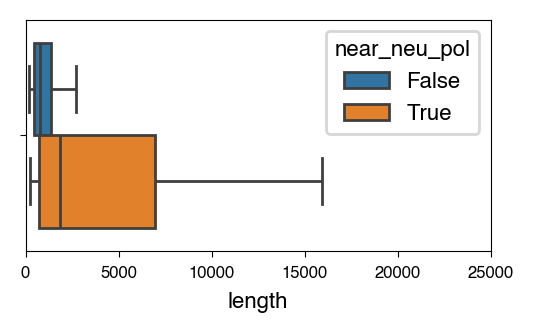

In [36]:
plt.figure(dpi=200, figsize=[3, 1.5])
sns.boxplot(data=cgi_mrg, x='length', hue='near_neu_pol', showfliers=False)
plt.xlim([0, 25000])

(0.0, 25000.0)

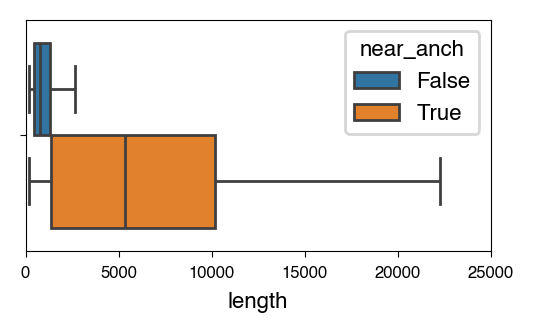

In [37]:
plt.figure(dpi=200, figsize=[3, 1.5])
sns.boxplot(data=cgi_mrg, x='length', hue='near_anch', showfliers=False)
plt.xlim([0, 25000])

## How many active TFs have long CGIs

In [204]:
import re

# Extract gene names
hand_genes_all = hand_anch['genes'].dropna().str.split(',')
hand_genes_all = [item for sublist in hand_genes_all for item in sublist]

# remove transcripts and ncRNAs
regex = re.compile(r'(^LINC|^RNA|^MIR|^A[LCP][0-9]+|.*\-AS|.*\-DT|.*\-OT|^RF[0-9]+|^C[0-9]*orf[0-9]*)')
hand_pc = [i for i in hand_genes_all if not regex.match(i)]
print(len(hand_pc))
hand_pc[:5]

333


['PAX7', 'RUNX3', 'RNF220', 'TAL1', 'FOXD2']

In [161]:
human_tf_path = "/tank/projects/schizophrenia_2021/data/lambert2018/DatabaseExtract_v_1.01.csv"
human_tf = pd.read_table(human_tf_path, sep=',')

print(human_tf.shape[0])
human_tf.head(n=2)

2765


,Unnamed: 0,Ensembl ID,HGNC symbol,DBD,Is TF?,TF assessment,Binding mode,Motif status,Final Notes,Final Comments,...,CisBP considers it a TF?,TFCat classification,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?
0,0,ENSG00000137203,TFAP2A,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,NaN,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False
1,1,ENSG00000008196,TFAP2B,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,NaN,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000008196#GO:0000981#sequence-specific...,$#ENSP00000377265#ENSG00000008196#ENST00000393...,False


In [205]:
tf_lst = human_tf.loc[human_tf['Is TF?'] == 'Yes', 'Ensembl ID']
tf_expr = koz_cnts.loc[koz_cnts['gene.id'].isin(tf_lst)]
tf_expr.loc[:, 'hand'] = tf_expr['gene.name'].isin(hand_pc)
tf_expr.head()

/tmp/ipykernel_1027415/2144430799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_expr.loc[:, 'hand'] = tf_expr['gene.name'].isin(hand_pc)


,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG,hand
9,ENSG00000001167,chr6,41070973,41104403,NFYA,protein_coding,+,3.694354,4.563397,6.335711,False
64,ENSG00000004848,chrX,25001693,25018420,ARX,protein_coding,-,2.713939,6.815607,1.646826,False
77,ENSG00000005073,chr7,27179156,27187232,HOXA11,protein_coding,-,0.000000,0.000000,0.000000,True
80,ENSG00000005102,chr17,43638388,43663922,MEOX1,protein_coding,-,0.011114,0.010843,0.024353,False
102,ENSG00000005513,chr16,979769,988979,SOX8,protein_coding,+,5.018837,2.020010,8.403696,False


In [206]:
# TFs
add_feature(cgi_mrg, tf_expr, 'near_TF')

<Axes: ylabel='length'>

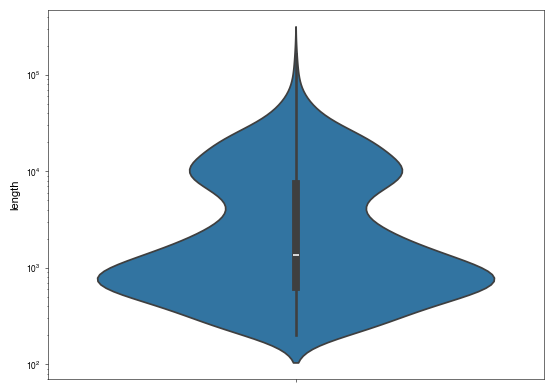

In [207]:
sns.violinplot(cgi_mrg.loc[cgi_mrg['near_TF'], 'length'], log_scale=[False, 10])

In [208]:
tf_act = {ct: tf_expr.loc[tf_expr[f'log2TPM_pl_1_{ct}'] > 2] for ct in ['GLU', 'GABA']}
tf_act['GLU']

,gene.id,chrom,start,end,gene.name,gene.type,strand,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,log2TPM_pl_1_OLIG,hand
9,ENSG00000001167,chr6,41070973,41104403,NFYA,protein_coding,+,3.694354,4.563397,6.335711,False
64,ENSG00000004848,chrX,25001693,25018420,ARX,protein_coding,-,2.713939,6.815607,1.646826,False
102,ENSG00000005513,chr16,979769,988979,SOX8,protein_coding,+,5.018837,2.020010,8.403696,False
104,ENSG00000005801,chr11,3337260,3381222,ZNF195,protein_coding,-,4.636098,4.808720,5.089236,False
110,ENSG00000005889,chrX,24147172,24218255,ZFX,protein_coding,+,3.178422,3.384729,3.666092,False
...,...,...,...,...,...,...,...,...,...,...,...
51218,ENSG00000272602,chr4,51285,90208,ZNF595,protein_coding,+,3.678854,4.110016,3.825119,False
51596,ENSG00000273274,chr1,32463071,32498686,ZBTB8B,protein_coding,+,2.169163,2.213564,2.639090,False
52502,ENSG00000275111,chr2,95163431,95186317,ZNF2,protein_coding,+,2.758477,2.578222,2.846356,False
53985,ENSG00000278129,chr19,58276954,58304791,ZNF8,protein_coding,+,3.089203,3.311537,3.506545,False


In [209]:
for ct in ['GLU', 'GABA']: 
    add_feature(cgi_mrg, tf_act[ct], f'near_act_TF_{ct}')

<Axes: ylabel='length'>

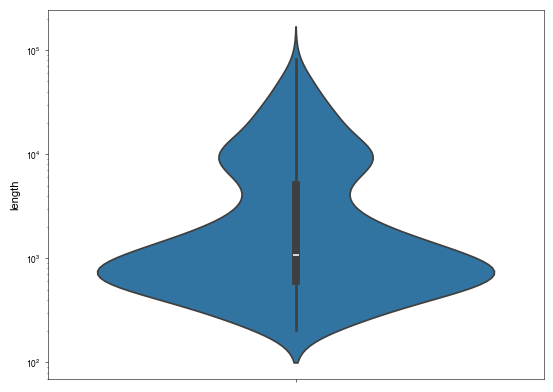

In [210]:
sns.violinplot(cgi_mrg.loc[cgi_mrg['near_act_TF_GLU'], 'length'], log_scale=[False, 10])

<Axes: ylabel='length'>

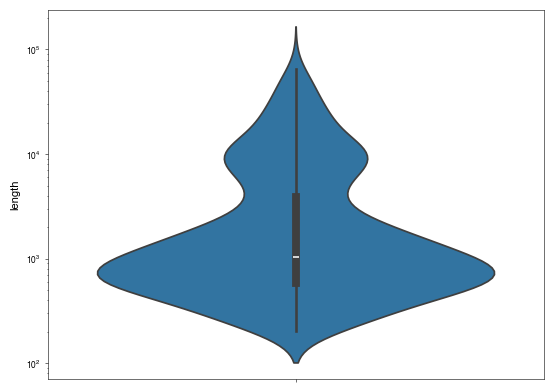

In [211]:
sns.violinplot(cgi_mrg.loc[cgi_mrg['near_act_TF_GABA'], 'length'], log_scale=[False, 10])

What active TFs have long CGI?

In [212]:
# Get gene tss
chrom_sizes_path = '/tank/projects/references/Homo_sapiens/GRCh38/chromosome_sizes/hg38.chrom.sizes'
bed_cols = ['chrom', 'start', 'end', 'gene.id', 'gene.name', 'strand', 
            'gene.type', 'log2TPM_pl_1_GLU', 'log2TPM_pl_1_GABA', 'hand']
tf_expr_tss = pbt.from_dataframe(tf_expr[bed_cols])\
             .flank(g=chrom_sizes_path, s=True, l=1, r=0)\
             .to_dataframe(names=bed_cols)

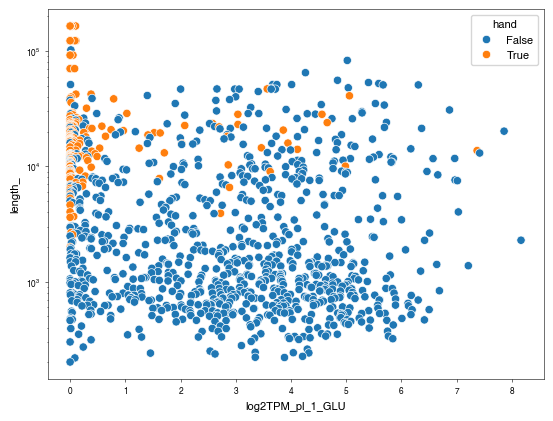

In [213]:
tf_cgi = bf.overlap(bf.expand(tf_expr_tss, 2000), cgi_mrg, how='inner')\
    .sort_values('length_', ascending=False)\
    .drop_duplicates('gene.name', keep='first')

sns.scatterplot(data=tf_cgi, x='log2TPM_pl_1_GLU', y='length_', hue='hand')
plt.yscale('log')

<Axes: ylabel='log2TPM_pl_1_GABA'>

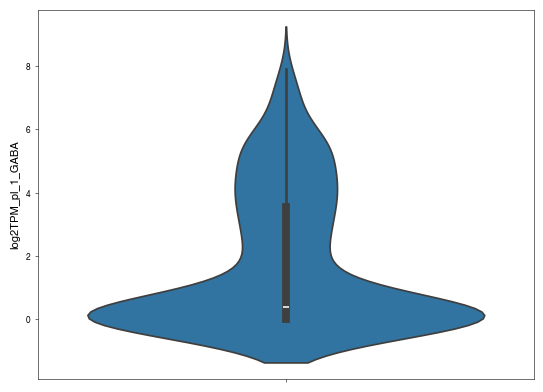

In [214]:
sns.violinplot(tf_cgi.loc[tf_cgi['length_'] > 8e3, 'log2TPM_pl_1_GABA'])

In [217]:
tf_cgi.loc[(tf_cgi['log2TPM_pl_1_GABA'] < 0.25) & (tf_cgi['length_'] > 8e3) & (~tf_cgi['hand'])]

,chrom,start,end,gene.id,gene.name,strand,gene.type,log2TPM_pl_1_GLU,log2TPM_pl_1_GABA,hand,...,near_expr_GLU_,near_me3_GLU_,near_expr_GABA_,near_me3_GABA_,near_bmi1_,near_atac_,near_anch_,near_TF_,near_act_TF_GLU_,near_act_TF_GABA_
167,chr7,27238698,27242699,ENSG00000106038,EVX1,+,protein_coding,0.000000,0.000000,False,...,False,True,False,True,True,True,True,True,False,False
1005,chr18,79391854,79395855,ENSG00000131196,NFATC1,+,protein_coding,0.014329,0.027827,False,...,False,True,False,True,True,True,False,True,False,False
555,chr12,53986622,53990623,ENSG00000197757,HOXC6,+,protein_coding,0.000000,0.005819,False,...,True,True,False,True,True,False,True,True,False,False
1063,chr8,143243108,143247109,ENSG00000264668,ENSG00000264668,+,protein_coding,0.008178,0.015914,False,...,True,False,True,False,True,True,False,True,True,True
965,chr10,133233853,133237854,ENSG00000151650,VENTX,+,protein_coding,0.000000,0.056413,False,...,True,False,True,True,True,False,False,True,False,False
365,chr19,12887201,12891202,ENSG00000105610,KLF1,-,protein_coding,0.083933,0.000000,False,...,True,False,True,True,True,True,False,True,False,False
334,chr19,1749504,1753505,ENSG00000205922,ONECUT3,+,protein_coding,0.008716,0.000000,False,...,False,True,False,True,True,False,False,True,False,False
410,chr19,45769252,45773253,ENSG00000177045,SIX5,-,protein_coding,0.246543,0.051526,False,...,True,False,True,False,True,True,False,True,False,False
1093,chr8,144287589,144291590,ENSG00000185122,HSF1,+,protein_coding,0.040962,0.010098,False,...,True,False,True,False,False,True,False,True,True,True
761,chr1,6240177,6244178,ENSG00000173673,HES3,+,protein_coding,0.000000,0.158392,False,...,True,False,True,False,True,True,False,True,False,False


# H3K27me3 confinement

For H3K27me3 from Kozlenkov2018, calculate confinement score (FSC) as in [Krug et al](https://www.biorxiv.org/content/10.1101/2023.11.28.567931v1.full)

In [27]:
fsc_df.index.to_series().str.split('_', expand=True)

,0,1
OLIG_REP1,OLIG,REP1
GLU_REP2,GLU,REP2
GLU_REP1,GLU,REP1
GABA_REP1,GABA,REP1
OLIG_REP2,OLIG,REP2
GABA_REP2,GABA,REP2


In [16]:
from os import listdir
import re

In [29]:
fsc_dir = '/tank/projects/polycomb/results/2025.04.15/results/bwa/mergedLibrary/SSP/'
fsc_samps = listdir(fsc_dir)
fsc = {}

for samp in fsc_samps:
    df = pd.read_table(fsc_dir + samp)
    samp_name = re.sub("ssp.", "", df.loc[0, 'Sample'])
    samp_name = re.sub(".mLb.*", "", samp_name)
    fsc[samp_name] = df.loc[0, 'FCS(10k)']

fsc_df = pd.Series(fsc, name='fsc').to_frame()
fsc_df[['ct', 'rep']] = fsc_df.index.to_series().str.split('_', expand=True)
fsc_df.sort_values('ct', inplace=True)
fsc_df

,fsc,ct,rep
GABA_REP1,0.059321,GABA,REP1
GABA_REP2,0.048301,GABA,REP2
GLU_REP2,0.050461,GLU,REP2
GLU_REP1,0.050469,GLU,REP1
OLIG_REP1,0.036108,OLIG,REP1
OLIG_REP2,0.024171,OLIG,REP2


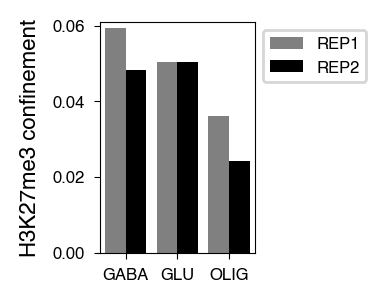

In [68]:
plt.figure(figsize=[1, 1.5], dpi=200)
# sns.swarmplot(data=fsc_df, y='fsc', x='ct', c='k')
sns.barplot(data=fsc_df, y='fsc', x='ct', hue='rep', palette=['grey', 'black'])


# for rep in ['REP1', 'REP2']:
#     sns.lineplot(data=fsc_df.loc[fsc_df['rep'] == rep], x='ct', y='fsc')

# sns.scatterplot(data=fsc_df, x='ct', y='fsc', hue='rep', size=1, legend=False, palette=['k', 'k'])
# sns.lineplot(data=fsc_df, x='ct', y='fsc', hue='rep', legend=False, palette=['k', 'k'])
plt.ylim([0, 0.061])
plt.xlabel('')
plt.ylabel('H3K27me3 confinement')
plt.legend(loc='upper left', bbox_to_anchor=[1, 1], fontsize=6)

# ATAC-seq

In [161]:
# Overlap with features
def add_feature(cgi_df, feature_df, col_name):
    cgi_olap = bf.overlap(cgi_df, feature_df, how='inner', return_index=True)\
        .drop_duplicates(['chrom', 'start', 'end'])

    # Write info to cgi table
    cgi_df[col_name] = False
    cgi_df.loc[cgi_olap['index'], col_name] = True
    return


# Cell type-specific features
for ct in ['GLU', 'GABA']:
    # Gene expression
    expr_gene_ct = koz_cnts.loc[koz_cnts[f'log2TPM_pl_1_{ct}'] > 0.25]
    add_feature(atac_peak, expr_gene_ct, f'near_expr_{ct}')

    # H3K27me3
    add_feature(atac_peak, bf.expand(me3_ct[ct], 1000), f'near_me3_{ct}')

# BMI1
add_feature(atac_peak, bmi_peak, 'near_bmi1')

# CGI
add_feature(atac_peak, cgi, 'near_cgi')

# CTCF
add_feature(atac_peak, ctcf_peak, 'near_ctcf')

# BHLHE40
add_feature(atac_peak, bhlh_peak, 'near_bhlhe40')

# Pol2
add_feature(atac_peak, pol2_peak, 'near_pol2')

# Dot anchors
add_feature(atac_peak, hand_anch, 'near_anch')

In [164]:
atac_peak.loc[atac_peak['near_anch']].sum(axis=0)

chrom             chr3chr7chr6chr6chr2chr13chr10chr6chr10chr11ch...
start                                                   10504671216
end                                                     10504810240
name              .................................................
score                                                        113791
strand            .................................................
fc                                                        631.09672
-log10p                                                  6858.87226
-log10q                                                  6507.76936
relSummit                                                     70975
near_expr_GLU                                                    89
near_me3_GLU                                                     49
near_expr_GABA                                                   77
near_me3_GABA                                                    76
near_bmi1                                       

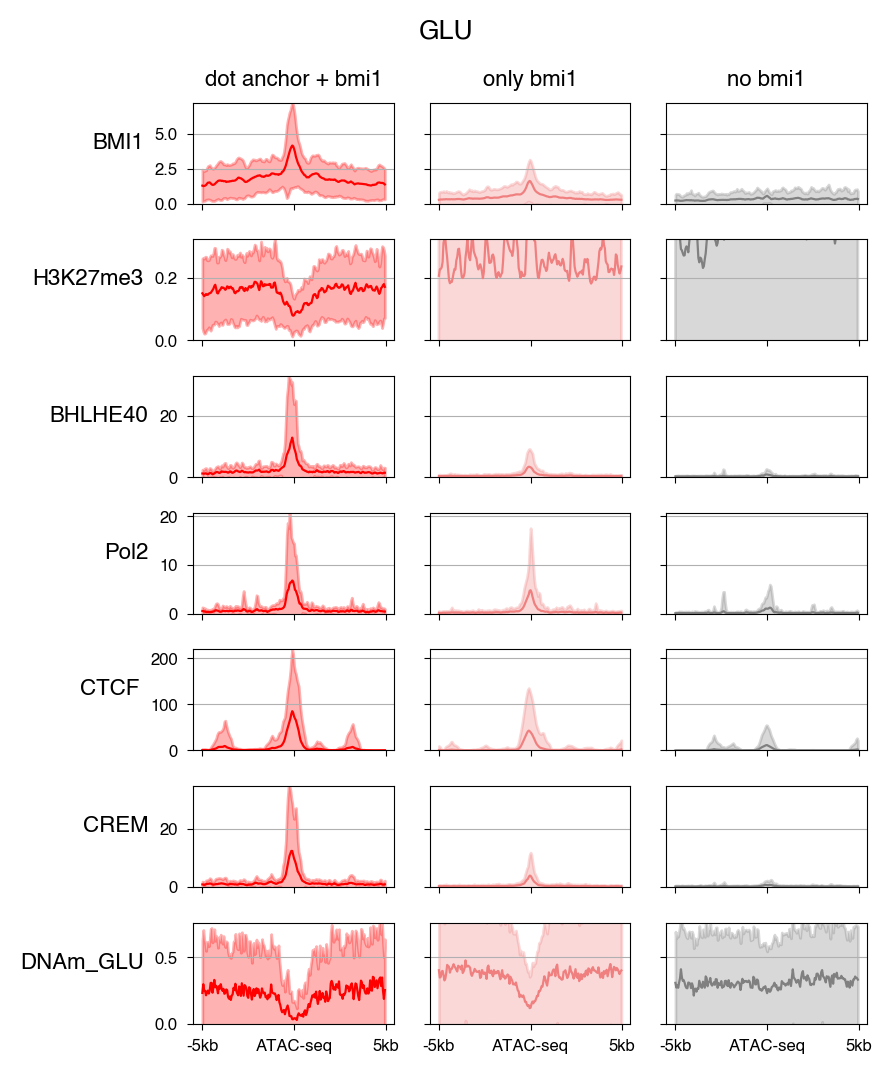

In [166]:
# plot average profiles
ct = 'GLU'
offset, nbins = 5_000, 200

prof_paths = {
    "BMI1": "/tank/projects/rina/tian23/new_bmi/new_bmi_result/bwa/merged_library/bigwig/BMI1_NEUN_DLPFC_merged.bigWig",
    "H3K27me3": f"/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/{ct}.merged.bigWig",
    # "ATAC-seq": "/media/backup2/PsychEncode/BrainTF/ATAC-seq/1224_1230_DLPFC_NeuN_basename_prefix.pooled.pval.signal.bigwig",
    "BHLHE40": "/media/backup2/PsychEncode/BrainTF/processed/BHLHE40_DLPFC-NeuN_Output_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    "Pol2": "/media/backup2/PsychEncode/BrainTF/processed/Pol2_DLPFC-NeuN_Output_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    "CTCF": "/media/backup2/PsychEncode/BrainTF/processed/CTCF_DLPFC-NEUN_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    "CREM": "/media/backup2/PsychEncode/BrainTF/processed/CREM_DLPFC-NEUN_Output_basename_prefix.pooled_x_basename_prefix.pooled.pval.signal.bigwig",
    "DNAm_GLU": "/tank/projects/polycomb/data/heffel/methylation/bigwig/allc_adult_Exc-L6-ASTN1_pseudobulk_final.CGN-both.frac.bw"
}

me3_grps = {
    'dot anchor + bmi1': atac_peak.loc[atac_peak[f"near_me3_{ct}"] & atac_peak['near_anch'] & atac_peak['near_bmi1']],
    'only bmi1': atac_peak.loc[atac_peak[f"near_me3_{ct}"] & ~atac_peak['near_anch'] & atac_peak['near_bmi1']],
    'no bmi1': atac_peak.loc[atac_peak[f"near_me3_{ct}"] & ~atac_peak['near_anch'] & ~atac_peak['near_bmi1']],
}
grp_color = ['red', 'lightcoral', 'grey']

fig, axs = plt.subplots(len(prof_paths), len(me3_grps), dpi=200, 
                        figsize=[1.5 * len(me3_grps), 0.7 * len(prof_paths) + 0.5], 
                        sharey='row', sharex=True)

for j, (grp_name, grp_df) in enumerate(me3_grps.items()):
    plot_df = grp_df.copy(deep=True)
    plot_df['mid'] = (plot_df['start'] + plot_df['end']) / 2
    plot_df['start'] = plot_df['mid'] - offset
    plot_df['end'] = plot_df['mid'] + offset
    
    for i, (prof, path) in enumerate(prof_paths.items()):
        s = bbi.stackup(path, plot_df['chrom'], plot_df['start'], plot_df['end'], 
                        bins=nbins)
        s_mean = np.nanmean(s, axis=0)
        s_std = np.nanstd(s, axis=0)

        ax = axs[i, j] 
        ax.plot(s_mean, linewidth=0.8, c=grp_color[j])
        ax.fill_between(np.arange(nbins), s_mean-s_std, s_mean+s_std, 
                        alpha=0.3, color=grp_color[j])
        # ax.fill_between(np.arange(nbins), [0]*nbins, np.mean(s, axis=0))

        ax.set_xticks([0, nbins//2, nbins], [f"{-offset//1000}kb", 'ATAC-seq', f"{offset//1000}kb"])
        ax.grid(axis='y', which='both', linewidth=0.4)

        if j == 0:
            ax.set_ylim([0, (s_mean+s_std).max()])
            ax.set_ylabel(prof, rotation='horizontal', ha='right')
        if i == 0:
            ax.set_title(grp_name)

plt.suptitle(ct)
plt.tight_layout()

In [170]:
bf.merge(bhlh_peak).head()

,chrom,start,end,n_intervals
0,chr1,778498,779068,1
1,chr1,958966,959536,1
2,chr1,1013130,1013903,2
3,chr1,1217733,1218303,1
4,chr1,1304576,1305345,2
